In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
import os
import relative_accuracy as ra
from statistics import mean, stdev

In [3]:
import keras_tuner as kt
from keras_tuner import RandomSearch

In [4]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [5]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5.npz")['x'] 
Output_train_5 = np.load("Deep_train_5.npz")['y']

Deep_test_5   = np.load("Deep_test_5.npz")['x'] 
Output_test_5 = np.load("Deep_test_5.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15.npz")['x'] 
Output_train_15 = np.load("Deep_train_15.npz")['y']

Deep_test_15   = np.load("Deep_test_15.npz")['x'] 
Output_test_15 = np.load("Deep_test_15.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30.npz")['x'] 
Output_train_30 = np.load("Deep_train_30.npz")['y']

Deep_test_30   = np.load("Deep_test_30.npz")['x'] 
Output_test_30 = np.load("Deep_test_30.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60.npz")['x'] 
Output_train_60 = np.load("Deep_train_60.npz")['y']

Deep_test_60   = np.load("Deep_test_60.npz")['x'] 
Output_test_60 = np.load("Deep_test_60.npz")['y']

In [6]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

In [7]:
Test      = pd.read_csv('01test_scaled.csv', index_col=0, parse_dates=[8])

# Reshape Samples

The first step is to split the input sequences into subsequences that can be processed by the CNN model. Here, each spatio-temporal sample can be split into three sub-samples, each with five time steps. The CNN can interpret each subsequence of five time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

In [8]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 7              # No of loop detectors
n_seq = 3                    # Subsequences
n_steps = 5                  # time-step per subsequence
val_percent = 0.12962        # 2 weeks
batch_size = 32

#### 5 mins

In [9]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt5 = Deep_train_5.reshape((Deep_train_5.shape[0], n_seq, n_steps, n_features))
yt5 = Output_train_5

In [10]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv5 = Deep_test_5.reshape((Deep_test_5.shape[0], n_seq, n_steps, n_features))
yv5 = Output_test_5

#### 15 mins

In [11]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt15 = Deep_train_15.reshape((Deep_train_15.shape[0], n_seq, n_steps, n_features))
yt15 = Output_train_15

In [12]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv15 = Deep_test_15.reshape((Deep_test_15.shape[0], n_seq, n_steps, n_features))
yv15 = Output_test_15

#### 30 mins

In [13]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt30 = Deep_train_30.reshape((Deep_train_30.shape[0], n_seq, n_steps, n_features))
yt30 = Output_train_30

In [14]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv30 = Deep_test_30.reshape((Deep_test_30.shape[0], n_seq, n_steps, n_features))
yv30 = Output_test_30

#### 60 mins

In [15]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt60 = Deep_train_60.reshape((Deep_train_60.shape[0], n_seq, n_steps, n_features))
yt60 = Output_train_60

In [16]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv60 = Deep_test_60.reshape((Deep_test_60.shape[0], n_seq, n_steps, n_features))
yv60 = Output_test_60

### Reshaping the Data for Conv2D layer

For Conv2D, there is a need to add one more dimension to show we're dealing with 1 channel (since technically the images are in black and white, only showing values from 0-max flow on a single channel).

Conv1D - strides in 1 dimension
Conv2D - strides in 2 dimensions

In [17]:
# define no_of_channels
n_channels = 1

In [18]:
# Train data
Xt5  =  Xt5.reshape(Xt5.shape[0], n_seq, n_steps, n_features, n_channels)
Xt15 =  Xt15.reshape(Xt15.shape[0], n_seq, n_steps, n_features, n_channels)
Xt30 =  Xt30.reshape(Xt30.shape[0], n_seq, n_steps, n_features, n_channels)
Xt60 =  Xt60.reshape(Xt60.shape[0], n_seq, n_steps, n_features, n_channels)

# Validation data
Xv5  =  Xv5.reshape(Xv5.shape[0], n_seq, n_steps, n_features, n_channels)
Xv15 =  Xv15.reshape(Xv15.shape[0], n_seq, n_steps, n_features, n_channels)
Xv30 =  Xv30.reshape(Xv30.shape[0], n_seq, n_steps, n_features, n_channels)
Xv60 =  Xv60.reshape(Xv60.shape[0], n_seq, n_steps, n_features, n_channels)

In [19]:
Xv5.shape

(4017, 3, 5, 7, 1)

# CNN-LSTM model

In [20]:
from tensorflow import keras

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [21]:
stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 5,
    restore_best_weights = True)

# 5 mins ahead

In [22]:
def build_model_5(hp):
    # Inputs
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Deep Model
    # CNN 
    CNN_5 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_5 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_5)
    # LSTM          
    LSTM_5 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_5)
    
    # Output
    output = keras.layers.Dense(1, name= "output")(LSTM_5)
    
    # Model
    model_5 = keras.Model(inputs=[channel_Deep], outputs=[output])

    # Compile
    model_5.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_5

In [23]:
tuner5 = RandomSearch(
    build_model_5,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/Runs'),
    project_name="7b-CNN-LSTM-5",
)

INFO:tensorflow:Reloading Oracle from existing project C:\Runs\7b-CNN-LSTM-5\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Runs\7b-CNN-LSTM-5\tuner0.json


In [24]:
tuner5.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [25]:
tuner5.search(Xt5, yt5, epochs=200,
           validation_split = val_percent,
           callbacks = [early_stop],
           verbose=2)

INFO:tensorflow:Oracle triggered exit


In [26]:
tuner5.results_summary(1)

Results summary
Results in C:\Runs\7b-CNN-LSTM-5
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 256
kernel_size: 2
units_LSTM: 64
learning_rate: 0.001
Score: 0.0015662849182263017


### Best Model

In [27]:
best_hp5 = tuner5.get_best_hyperparameters()[0]
model5 = tuner5.hypermodel.build(best_hp5)

In [28]:
scaler_filename = "Best_HP/7b-ConvLSTM-5"
joblib.dump(best_hp5, scaler_filename) 

['Best_HP/7b-ConvLSTM-5']

In [29]:
model5.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DeepInput (InputLayer)       [(None, None, 5, 7, 1)]   0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 4, 6, 256)   1280      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 6144)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                1589504   
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 1,590,849
Trainable params: 1,590,849
Non-trainable params: 0
_________________________________________________________________


In [30]:
# model5.fit((Xt5), yt5, 
#            epochs = 100, 
#            verbose = 0)

In [31]:
# metrics5 = pd.DataFrame(model5.history.history)

In [32]:
# metrics5[['loss']].plot()

In [33]:
MSE5  = []
MAE5  = []
RMSE5 = []
MAPE5 = []

for i in range(100):
    print(f"run: {i+1}")
    model5.fit((Xt5), yt5, 
           epochs = 200, validation_split = val_percent,
           callbacks = [stop],
           verbose = 1)

    test_predictions5 = model5.predict((Xv5))

    yv5 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv5 = yv5[15:,4]

    df = Test.drop(Test.head(15).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f5'] = pd.Series(test_predictions5.flatten())

    test_predictions5 = scaler.inverse_transform(df)

    test_predictions5 = test_predictions5[:,4]

    MSE5.append(mean_squared_error(yv5,test_predictions5))

    MAE5.append(mean_absolute_error(yv5,test_predictions5))

    RMSE5.append(np.sqrt(mean_squared_error(yv5,test_predictions5)))

    MAPE5.append(mean_absolute_percentage_error(yv5,test_predictions5)*100)

    
    current_mse = mean_squared_error(yv5,test_predictions5)
    if all(i > current_mse for i in MSE5):
        model5.save("my_dir/7b-CNN-LSTM-5")

eval5 = [mean(MSE5), mean(MAE5), mean(RMSE5), mean(MAPE5)]
std5 = [stdev(MSE5), stdev(MAE5), stdev(RMSE5), stdev(MAPE5)]
print(eval5)

run: 1
Epoch 1/200
846/846 [==============================] - 42s 50ms/step - loss: 0.0032 - mean_absolute_error: 0.0386 - root_mean_squared_error: 0.0563 - mean_absolute_percentage_error: 3365.1863 - val_loss: 0.0020 - val_mean_absolute_error: 0.0350 - val_root_mean_squared_error: 0.0443 - val_mean_absolute_percentage_error: 12.2411
Epoch 2/200
846/846 [==============================] - 39s 46ms/step - loss: 0.0020 - mean_absolute_error: 0.0338 - root_mean_squared_error: 0.0451 - mean_absolute_percentage_error: 3794.2488 - val_loss: 0.0017 - val_mean_absolute_error: 0.0321 - val_root_mean_squared_error: 0.0417 - val_mean_absolute_percentage_error: 9.7487
Epoch 3/200
846/846 [==============================] - 40s 47ms/step - loss: 0.0020 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0443 - mean_absolute_percentage_error: 2912.1033 - val_loss: 0.0017 - val_mean_absolute_error: 0.0314 - val_root_mean_squared_error: 0.0408 - val_mean_absolute_percentage_error: 9.3504
Epoch 4/

846/846 [==============================] - 38s 45ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0400 - mean_absolute_percentage_error: 2942.2222 - val_loss: 0.0017 - val_mean_absolute_error: 0.0314 - val_root_mean_squared_error: 0.0406 - val_mean_absolute_percentage_error: 9.8797
Epoch 11/200
846/846 [==============================] - 37s 43ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0401 - mean_absolute_percentage_error: 3019.5144 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302 - val_root_mean_squared_error: 0.0395 - val_mean_absolute_percentage_error: 9.0635
Epoch 12/200
846/846 [==============================] - 38s 44ms/step - loss: 0.0016 - mean_absolute_error: 0.0299 - root_mean_squared_error: 0.0399 - mean_absolute_percentage_error: 2256.7744 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302 - val_root_mean_squared_error: 0.0395 - val_mean_absolute_percentage_error: 9.1275
Epoch 13/200
846/846 [====

846/846 [==============================] - 37s 44ms/step - loss: 0.0014 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.0378 - mean_absolute_percentage_error: 2783.5708 - val_loss: 0.0018 - val_mean_absolute_error: 0.0327 - val_root_mean_squared_error: 0.0426 - val_mean_absolute_percentage_error: 10.0595
run: 10
Epoch 1/200
846/846 [==============================] - 38s 44ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0384 - mean_absolute_percentage_error: 2143.5212 - val_loss: 0.0018 - val_mean_absolute_error: 0.0325 - val_root_mean_squared_error: 0.0424 - val_mean_absolute_percentage_error: 9.7356
Epoch 2/200
846/846 [==============================] - 36s 42ms/step - loss: 0.0015 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 2848.4802 - val_loss: 0.0016 - val_mean_absolute_error: 0.0310 - val_root_mean_squared_error: 0.0403 - val_mean_absolute_percentage_error: 9.3989
Epoch 3/200
846/846

Epoch 7/200
846/846 [==============================] - 38s 46ms/step - loss: 0.0013 - mean_absolute_error: 0.0275 - root_mean_squared_error: 0.0365 - mean_absolute_percentage_error: 2834.0161 - val_loss: 0.0018 - val_mean_absolute_error: 0.0327 - val_root_mean_squared_error: 0.0425 - val_mean_absolute_percentage_error: 10.3911
Epoch 8/200
846/846 [==============================] - 37s 44ms/step - loss: 0.0013 - mean_absolute_error: 0.0273 - root_mean_squared_error: 0.0362 - mean_absolute_percentage_error: 3121.3406 - val_loss: 0.0016 - val_mean_absolute_error: 0.0311 - val_root_mean_squared_error: 0.0406 - val_mean_absolute_percentage_error: 9.1758
Epoch 9/200
846/846 [==============================] - 38s 45ms/step - loss: 0.0013 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0362 - mean_absolute_percentage_error: 3427.3333 - val_loss: 0.0017 - val_mean_absolute_error: 0.0315 - val_root_mean_squared_error: 0.0412 - val_mean_absolute_percentage_error: 9.3909
Epoch 10/200
84

846/846 [==============================] - 38s 45ms/step - loss: 0.0012 - mean_absolute_error: 0.0263 - root_mean_squared_error: 0.0348 - mean_absolute_percentage_error: 2397.7202 - val_loss: 0.0018 - val_mean_absolute_error: 0.0324 - val_root_mean_squared_error: 0.0426 - val_mean_absolute_percentage_error: 9.6062
Epoch 3/200
846/846 [==============================] - 38s 45ms/step - loss: 0.0012 - mean_absolute_error: 0.0263 - root_mean_squared_error: 0.0346 - mean_absolute_percentage_error: 2023.4017 - val_loss: 0.0018 - val_mean_absolute_error: 0.0322 - val_root_mean_squared_error: 0.0419 - val_mean_absolute_percentage_error: 10.0367
Epoch 4/200
846/846 [==============================] - 38s 45ms/step - loss: 0.0012 - mean_absolute_error: 0.0262 - root_mean_squared_error: 0.0345 - mean_absolute_percentage_error: 3008.8896 - val_loss: 0.0018 - val_mean_absolute_error: 0.0324 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 10.0031
Epoch 5/200
846/846 [=====

Epoch 4/200
846/846 [==============================] - 38s 45ms/step - loss: 0.0011 - mean_absolute_error: 0.0248 - root_mean_squared_error: 0.0326 - mean_absolute_percentage_error: 2927.9287 - val_loss: 0.0019 - val_mean_absolute_error: 0.0338 - val_root_mean_squared_error: 0.0440 - val_mean_absolute_percentage_error: 10.2139
Epoch 5/200
846/846 [==============================] - 39s 46ms/step - loss: 0.0011 - mean_absolute_error: 0.0247 - root_mean_squared_error: 0.0324 - mean_absolute_percentage_error: 2325.5173 - val_loss: 0.0019 - val_mean_absolute_error: 0.0336 - val_root_mean_squared_error: 0.0441 - val_mean_absolute_percentage_error: 10.1479
Epoch 6/200
846/846 [==============================] - 38s 45ms/step - loss: 0.0011 - mean_absolute_error: 0.0247 - root_mean_squared_error: 0.0324 - mean_absolute_percentage_error: 2312.2290 - val_loss: 0.0020 - val_mean_absolute_error: 0.0335 - val_root_mean_squared_error: 0.0442 - val_mean_absolute_percentage_error: 9.8043
run: 28
Epoch 

846/846 [==============================] - 39s 46ms/step - loss: 9.4927e-04 - mean_absolute_error: 0.0235 - root_mean_squared_error: 0.0308 - mean_absolute_percentage_error: 2063.0447 - val_loss: 0.0021 - val_mean_absolute_error: 0.0344 - val_root_mean_squared_error: 0.0455 - val_mean_absolute_percentage_error: 10.0788
Epoch 9/200
846/846 [==============================] - 38s 45ms/step - loss: 9.2869e-04 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0305 - mean_absolute_percentage_error: 2364.7151 - val_loss: 0.0021 - val_mean_absolute_error: 0.0344 - val_root_mean_squared_error: 0.0455 - val_mean_absolute_percentage_error: 10.0922- loss: 9.2550e-04 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0304 - mean_a - ETA: 2s - loss: 9.3071e-04 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0305 - mean_absolute_percentage_error - ETA: 1s - loss: 9.2900e-04 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0305 - mean_absolute_perce
Epoch 10/200
8

846/846 [==============================] - 37s 43ms/step - loss: 8.4723e-04 - mean_absolute_error: 0.0223 - root_mean_squared_error: 0.0291 - mean_absolute_percentage_error: 2825.2654 - val_loss: 0.0021 - val_mean_absolute_error: 0.0344 - val_root_mean_squared_error: 0.0454 - val_mean_absolute_percentage_error: 10.2057
Epoch 5/200
846/846 [==============================] - 38s 45ms/step - loss: 8.4650e-04 - mean_absolute_error: 0.0224 - root_mean_squared_error: 0.0291 - mean_absolute_percentage_error: 2571.1926 - val_loss: 0.0022 - val_mean_absolute_error: 0.0352 - val_root_mean_squared_error: 0.0468 - val_mean_absolute_percentage_error: 10.4387
Epoch 6/200
846/846 [==============================] - 38s 45ms/step - loss: 8.4119e-04 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0290 - mean_absolute_percentage_error: 2656.9946 - val_loss: 0.0021 - val_mean_absolute_error: 0.0342 - val_root_mean_squared_error: 0.0454 - val_mean_absolute_percentage_error: 9.9897
Epoch 7/200
84

846/846 [==============================] - 37s 44ms/step - loss: 7.0414e-04 - mean_absolute_error: 0.0204 - root_mean_squared_error: 0.0265 - mean_absolute_percentage_error: 2523.6267 - val_loss: 0.0023 - val_mean_absolute_error: 0.0360 - val_root_mean_squared_error: 0.0479 - val_mean_absolute_percentage_error: 10.3609
Epoch 5/200
846/846 [==============================] - 38s 45ms/step - loss: 6.8809e-04 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0262 - mean_absolute_percentage_error: 2434.9216 - val_loss: 0.0022 - val_mean_absolute_error: 0.0353 - val_root_mean_squared_error: 0.0470 - val_mean_absolute_percentage_error: 10.3224
Epoch 6/200
846/846 [==============================] - 37s 44ms/step - loss: 6.9261e-04 - mean_absolute_error: 0.0203 - root_mean_squared_error: 0.0263 - mean_absolute_percentage_error: 2542.5288 - val_loss: 0.0023 - val_mean_absolute_error: 0.0359 - val_root_mean_squared_error: 0.0480 - val_mean_absolute_percentage_error: 10.2878
Epoch 7/200
8

846/846 [==============================] - 38s 45ms/step - loss: 5.9898e-04 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0245 - mean_absolute_percentage_error: 2199.1499 - val_loss: 0.0024 - val_mean_absolute_error: 0.0368 - val_root_mean_squared_error: 0.0494 - val_mean_absolute_percentage_error: 10.5866ot_mean_squared_error: 0.0244 - mean_abs - ETA: 6s - loss: 5.9933e-04 - mean_abso
Epoch 3/200
846/846 [==============================] - 39s 46ms/step - loss: 5.9539e-04 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0244 - mean_absolute_percentage_error: 2525.5657 - val_loss: 0.0024 - val_mean_absolute_error: 0.0366 - val_root_mean_squared_error: 0.0490 - val_mean_absolute_percentage_error: 10.8212
Epoch 4/200
846/846 [==============================] - 39s 46ms/step - loss: 5.8788e-04 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0242 - mean_absolute_percentage_error: 2315.8047 - val_loss: 0.0025 - val_mean_absolute_error: 0.0371 - val_root_mean_

846/846 [==============================] - 39s 46ms/step - loss: 5.0386e-04 - mean_absolute_error: 0.0174 - root_mean_squared_error: 0.0224 - mean_absolute_percentage_error: 2314.7124 - val_loss: 0.0026 - val_mean_absolute_error: 0.0375 - val_root_mean_squared_error: 0.0507 - val_mean_absolute_percentage_error: 10.7453
Epoch 4/200
846/846 [==============================] - 37s 44ms/step - loss: 4.8941e-04 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0221 - mean_absolute_percentage_error: 2356.2415 - val_loss: 0.0026 - val_mean_absolute_error: 0.0378 - val_root_mean_squared_error: 0.0511 - val_mean_absolute_percentage_error: 10.6569
Epoch 5/200
846/846 [==============================] - 38s 45ms/step - loss: 4.8448e-04 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0220 - mean_absolute_percentage_error: 2296.8687 - val_loss: 0.0027 - val_mean_absolute_error: 0.0381 - val_root_mean_squared_error: 0.0515 - val_mean_absolute_percentage_error: 10.7185
Epoch 6/200
8

846/846 [==============================] - 38s 45ms/step - loss: 4.0192e-04 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0200 - mean_absolute_percentage_error: 2261.0532 - val_loss: 0.0028 - val_mean_absolute_error: 0.0389 - val_root_mean_squared_error: 0.0530 - val_mean_absolute_percentage_error: 10.98920017e-04 -
Epoch 2/200
846/846 [==============================] - 38s 45ms/step - loss: 4.0099e-04 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0200 - mean_absolute_percentage_error: 1990.2201 - val_loss: 0.0029 - val_mean_absolute_error: 0.0395 - val_root_mean_squared_error: 0.0535 - val_mean_absolute_percentage_error: 11.2675
Epoch 3/200
846/846 [==============================] - 39s 46ms/step - loss: 4.0209e-04 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0201 - mean_absolute_percentage_error: 2626.8152 - val_loss: 0.0029 - val_mean_absolute_error: 0.0396 - val_root_mean_squared_error: 0.0537 - val_mean_absolute_percentage_error: 11.0556
Epo

Epoch 4/200
846/846 [==============================] - 42s 49ms/step - loss: 3.5882e-04 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0189 - mean_absolute_percentage_error: 2754.7783 - val_loss: 0.0029 - val_mean_absolute_error: 0.0398 - val_root_mean_squared_error: 0.0542 - val_mean_absolute_percentage_error: 11.0990 loss: 3.5825e-04 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0189 - mean_absolute_percent - ETA: 2s - loss: 3.5781e-04 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0189 - m
Epoch 5/200
846/846 [==============================] - 41s 48ms/step - loss: 3.4707e-04 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0186 - mean_absolute_percentage_error: 2659.1826 - val_loss: 0.0030 - val_mean_absolute_error: 0.0399 - val_root_mean_squared_error: 0.0544 - val_mean_absolute_percentage_error: 11.4141
Epoch 7/200
846/846 [==============================] - 40s 47ms/step - loss: 3.4547e-04 - mean_absolute_error: 0.0145 - root_mean_sq

846/846 [==============================] - 40s 47ms/step - loss: 3.2039e-04 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0179 - mean_absolute_percentage_error: 3352.3008 - val_loss: 0.0030 - val_mean_absolute_error: 0.0399 - val_root_mean_squared_error: 0.0544 - val_mean_absolute_percentage_error: 11.1701
Epoch 3/200
846/846 [==============================] - 41s 49ms/step - loss: 3.1440e-04 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0177 - mean_absolute_percentage_error: 2141.0176 - val_loss: 0.0031 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_percentage_error: 11.7978
Epoch 4/200
846/846 [==============================] - 42s 50ms/step - loss: 3.0399e-04 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0174 - mean_absolute_percentage_error: 2623.3386 - val_loss: 0.0030 - val_mean_absolute_error: 0.0403 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_percentage_error: 11.2943
Epoch 5/200
8

846/846 [==============================] - 38s 45ms/step - loss: 2.6485e-04 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0163 - mean_absolute_percentage_error: 2814.8274 - val_loss: 0.0032 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0563 - val_mean_absolute_percentage_error: 11.5251ot_mean_squ - ETA: 1s - loss: 2.6508e-04 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0163 - mean_absolute_percenta
Epoch 7/200
846/846 [==============================] - 41s 48ms/step - loss: 2.6826e-04 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0164 - mean_absolute_percentage_error: 2540.5537 - val_loss: 0.0032 - val_mean_absolute_error: 0.0414 - val_root_mean_squared_error: 0.0565 - val_mean_absolute_percentage_error: 12.1673
run: 79
Epoch 1/200
846/846 [==============================] - 40s 47ms/step - loss: 2.7676e-04 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0166 - mean_absolute_percentage_error: 2556.3345 - val_loss: 0

846/846 [==============================] - 39s 46ms/step - loss: 2.4432e-04 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0156 - mean_absolute_percentage_error: 2952.7422 - val_loss: 0.0033 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0576 - val_mean_absolute_percentage_error: 11.9850
Epoch 10/200
846/846 [==============================] - 40s 48ms/step - loss: 2.3267e-04 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0153 - mean_absolute_percentage_error: 2495.4695 - val_loss: 0.0034 - val_mean_absolute_error: 0.0422 - val_root_mean_squared_error: 0.0582 - val_mean_absolute_percentage_error: 11.9487
Epoch 11/200
846/846 [==============================] - 39s 46ms/step - loss: 2.3826e-04 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0154 - mean_absolute_percentage_error: 1900.9928 - val_loss: 0.0033 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0575 - val_mean_absolute_percentage_error: 12.0918
run: 85
Epo

846/846 [==============================] - 41s 49ms/step - loss: 2.2748e-04 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0151 - mean_absolute_percentage_error: 2778.7012 - val_loss: 0.0034 - val_mean_absolute_error: 0.0424 - val_root_mean_squared_error: 0.0585 - val_mean_absolute_percentage_error: 11.9265
Epoch 2/200
846/846 [==============================] - 41s 48ms/step - loss: 2.2192e-04 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0149 - mean_absolute_percentage_error: 2779.6367 - val_loss: 0.0035 - val_mean_absolute_error: 0.0427 - val_root_mean_squared_error: 0.0588 - val_mean_absolute_percentage_error: 12.0140
Epoch 3/200
846/846 [==============================] - 41s 48ms/step - loss: 2.2088e-04 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0149 - mean_absolute_percentage_error: 2677.7974 - val_loss: 0.0033 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0577 - val_mean_absolute_percentage_error: 11.8195ute_error: 0.0

846/846 [==============================] - 38s 45ms/step - loss: 1.9396e-04 - mean_absolute_error: 0.0109 - root_mean_squared_error: 0.0139 - mean_absolute_percentage_error: 1774.1615 - val_loss: 0.0035 - val_mean_absolute_error: 0.0433 - val_root_mean_squared_error: 0.0595 - val_mean_absolute_percentage_error: 12.0899
Epoch 9/200
846/846 [==============================] - 38s 45ms/step - loss: 1.8690e-04 - mean_absolute_error: 0.0106 - root_mean_squared_error: 0.0137 - mean_absolute_percentage_error: 2347.0073 - val_loss: 0.0035 - val_mean_absolute_error: 0.0433 - val_root_mean_squared_error: 0.0595 - val_mean_absolute_percentage_error: 12.3772
run: 95
Epoch 1/200
846/846 [==============================] - 39s 46ms/step - loss: 1.8984e-04 - mean_absolute_error: 0.0107 - root_mean_squared_error: 0.0138 - mean_absolute_percentage_error: 2783.4636 - val_loss: 0.0034 - val_mean_absolute_error: 0.0426 - val_root_mean_squared_error: 0.0585 - val_mean_absolute_percentage_error: 11.9998
Epoch

846/846 [==============================] - 39s 47ms/step - loss: 1.7281e-04 - mean_absolute_error: 0.0102 - root_mean_squared_error: 0.0131 - mean_absolute_percentage_error: 2218.0847 - val_loss: 0.0036 - val_mean_absolute_error: 0.0431 - val_root_mean_squared_error: 0.0597 - val_mean_absolute_percentage_error: 12.1265
Epoch 11/200
846/846 [==============================] - 37s 44ms/step - loss: 1.6616e-04 - mean_absolute_error: 0.0100 - root_mean_squared_error: 0.0129 - mean_absolute_percentage_error: 2095.0776 - val_loss: 0.0035 - val_mean_absolute_error: 0.0431 - val_root_mean_squared_error: 0.0593 - val_mean_absolute_percentage_error: 12.1728
[785.5741233680203, 20.874425465183233, 27.801915236091386, 8.880298534571061]


In [34]:
model5 = keras.models.load_model("my_dir/7b-CNN-LSTM-5") 

In [100]:
runs = {'MSE': MSE5, 'MAE': MAE5, 'RMSE': RMSE5, 'MAPE': MAPE5}
table5 = pd.DataFrame(data=runs)
table5.to_csv("Results/Runs/7b-CNN-LSTM-5")

In [102]:
pd.read_csv("Results/Runs/7b-CNN-LSTM-5", index_col=0)

,MSE,MAE,RMSE,MAPE
0,545.500834,17.798298,23.355959,7.983349
1,527.545755,17.478940,22.968364,7.670998
2,524.042671,17.404943,22.891978,7.672115
3,527.182919,17.517137,22.960464,7.740992
4,520.987082,17.354920,22.825141,7.628030
...,...,...,...,...
95,1066.327061,24.409198,32.654664,10.197803
96,1064.719194,24.277422,32.630035,10.030763
97,1082.174482,24.512897,32.896420,10.100275
98,1079.166390,24.494464,32.850668,10.132835


### Evaluation on inverse_transform

In [35]:
test_predictions5 = model5.predict((Xv5))

yv5 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv5 = yv5[15:,4]

df = Test.drop(Test.head(15).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f5'] = pd.Series(test_predictions5.flatten())

test_predictions5 = scaler.inverse_transform(df)

test_predictions5 = test_predictions5[:,4]

# MSE5 = mean_squared_error(yv5,test_predictions5)

# MAE5 = mean_absolute_error(yv5,test_predictions5)

# RMSE5 = np.sqrt(MSE5)

# MAPE5 = mean_absolute_percentage_error(yv5,test_predictions5)*100

# eval5 = [MSE5, MAE5, RMSE5, MAPE5]
# print(eval5)

In [36]:
RA10 = ra.RA_10(np.asarray(yv5), np.asarray(test_predictions5))
RA15 = ra.RA_15(np.asarray(yv5), np.asarray(test_predictions5))
RA20 = ra.RA_20(np.asarray(yv5), np.asarray(test_predictions5))

res5 = [RA10, RA15, RA20]
print(res5)

[70.12696041822255, 85.21284540702017, 93.10430669653971]


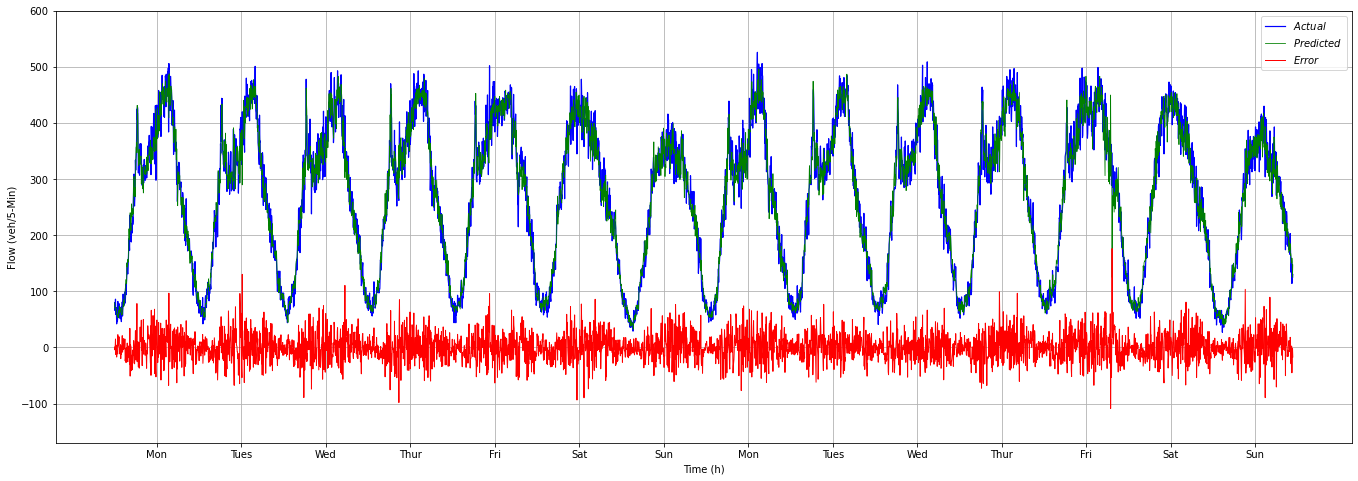

In [37]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv5, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions5, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv5-test_predictions5), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

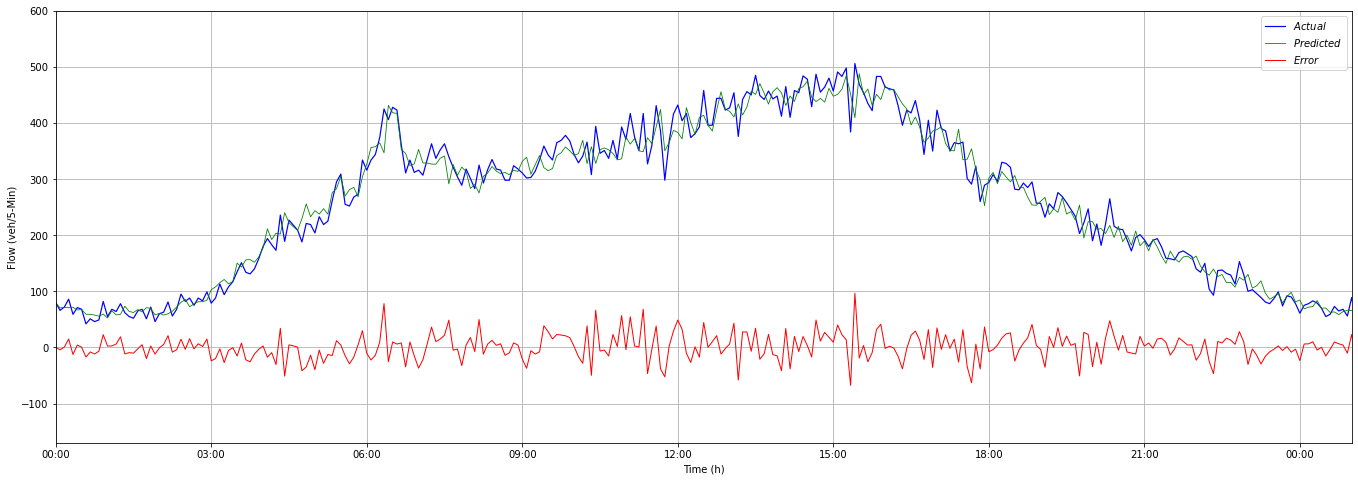

In [38]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv5, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions5, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv5-test_predictions5), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,300)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# 15 mins ahead

In [110]:
def build_model_15(hp):
    # Inputs
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Deep Model
    # CNN 
    CNN_15 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_15 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_15)
    # LSTM          
    LSTM_15 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_15)
        
    # Output
    output = keras.layers.Dense(1, name= "output")(LSTM_15)
    
    # Model
    model_15 = keras.Model(inputs=[channel_Deep], outputs=[output])

    # Compile
    model_15.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_15

In [111]:
tuner15 = RandomSearch(
    build_model_15,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/Runs'),
    project_name="7b-CNN-LSTM-15",
)

INFO:tensorflow:Reloading Oracle from existing project C:\Runs\7b-CNN-LSTM-15\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Runs\7b-CNN-LSTM-15\tuner0.json


In [112]:
tuner15.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [113]:
tuner15.search((Xt15), yt15, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop], 
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [114]:
tuner15.results_summary(1)

Results summary
Results in C:\Runs\7b-CNN-LSTM-15
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 224
kernel_size: 2
units_LSTM: 55
learning_rate: 0.001
Score: 0.002268888708204031


### Best model

In [115]:
best_hp15 = tuner15.get_best_hyperparameters()[0]
model15 = tuner15.hypermodel.build(best_hp15)

In [116]:
scaler_filename = "Best_HP/7b-ConvLSTM-15"
joblib.dump(best_hp15, scaler_filename) 

['Best_HP/7b-ConvLSTM-15']

In [117]:
model15.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DeepInput (InputLayer)       [(None, None, 5, 7, 1)]   0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 4, 6, 224)   1120      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 5376)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 55)                1195040   
_________________________________________________________________
output (Dense)               (None, 1)                 56        
Total params: 1,196,216
Trainable params: 1,196,216
Non-trainable params: 0
_________________________________________________________________


In [118]:
# model15.fit((Xt15), yt15, 
#             epochs = 100, 
#             verbose = 0)

In [119]:
# metrics15 = pd.DataFrame(model15.history.history)

In [120]:
# metrics15[['loss']].plot()

In [50]:
MSE15  = []
MAE15  = []
RMSE15 = []
MAPE15 = []

for i in range(100):
    print(f"run: {i+1}")
    model15.fit((Xt15), yt15, 
            epochs = 200, validation_split = val_percent,
            callbacks = [stop],
            verbose = 1)
    
    test_predictions15 = model15.predict((Xv15))

    yv15 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv15 = yv15[17:,4]

    df = Test.drop(Test.head(17).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f5'] = pd.Series(test_predictions15.flatten())

    test_predictions15 = scaler.inverse_transform(df)

    test_predictions15 = test_predictions15[:,4]

    MSE15.append(mean_squared_error(yv15,test_predictions15))

    MAE15.append(mean_absolute_error(yv15,test_predictions15))

    RMSE15.append(np.sqrt(mean_squared_error(yv15,test_predictions15)))

    MAPE15.append(mean_absolute_percentage_error(yv15,test_predictions15)*100)
    

    current_mse = mean_squared_error(yv15,test_predictions15)
    if all(i > current_mse for i in MSE15):
        model15.save("my_dir/7b-CNN-LSTM-15")

eval15 = [mean(MSE15), mean(MAE15), mean(RMSE15), mean(MAPE15)]
std15 = [stdev(MSE15), stdev(MAE15), stdev(RMSE15), stdev(MAPE15)]
print(eval15)

run: 1
Epoch 1/200
846/846 [==============================] - 33s 40ms/step - loss: 0.0041 - mean_absolute_error: 0.0453 - root_mean_squared_error: 0.0644 - mean_absolute_percentage_error: 4719.9995 - val_loss: 0.0028 - val_mean_absolute_error: 0.0402 - val_root_mean_squared_error: 0.0533 - val_mean_absolute_percentage_error: 12.4954
Epoch 2/200
846/846 [==============================] - 29s 34ms/step - loss: 0.0030 - mean_absolute_error: 0.0405 - root_mean_squared_error: 0.0547 - mean_absolute_percentage_error: 3336.3953 - val_loss: 0.0027 - val_mean_absolute_error: 0.0395 - val_root_mean_squared_error: 0.0521 - val_mean_absolute_percentage_error: 11.9706ean_absolute_error: 0.0401 - root_mean_squared_
Epoch 3/200
846/846 [==============================] - 31s 37ms/step - loss: 0.0029 - mean_absolute_error: 0.0399 - root_mean_squared_error: 0.0537 - mean_absolute_percentage_error: 4062.4214 - val_loss: 0.0031 - val_mean_absolute_error: 0.0422 - val_root_mean_squared_error: 0.0556 - val

846/846 [==============================] - 33s 39ms/step - loss: 0.0021 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0458 - mean_absolute_percentage_error: 3187.3713 - val_loss: 0.0025 - val_mean_absolute_error: 0.0375 - val_root_mean_squared_error: 0.0495 - val_mean_absolute_percentage_error: 11.0342
Epoch 2/200
846/846 [==============================] - 30s 36ms/step - loss: 0.0021 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0458 - mean_absolute_percentage_error: 2930.0625 - val_loss: 0.0024 - val_mean_absolute_error: 0.0368 - val_root_mean_squared_error: 0.0488 - val_mean_absolute_percentage_error: 11.1824
Epoch 3/200
846/846 [==============================] - 31s 37ms/step - loss: 0.0021 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0456 - mean_absolute_percentage_error: 2375.7749 - val_loss: 0.0023 - val_mean_absolute_error: 0.0366 - val_root_mean_squared_error: 0.0483 - val_mean_absolute_percentage_error: 11.3209_absolute_error: 0.0343 - 

Epoch 4/200
846/846 [==============================] - 30s 35ms/step - loss: 0.0019 - mean_absolute_error: 0.0323 - root_mean_squared_error: 0.0430 - mean_absolute_percentage_error: 2799.5283 - val_loss: 0.0024 - val_mean_absolute_error: 0.0372 - val_root_mean_squared_error: 0.0494 - val_mean_absolute_percentage_error: 11.2054d_error: 0.0431 - mean_absolute_percentage_error: 2
Epoch 6/200
846/846 [==============================] - 32s 37ms/step - loss: 0.0018 - mean_absolute_error: 0.0323 - root_mean_squared_error: 0.0429 - mean_absolute_percentage_error: 2936.0083 - val_loss: 0.0023 - val_mean_absolute_error: 0.0365 - val_root_mean_squared_error: 0.0484 - val_mean_absolute_percentage_error: 11.0457
run: 13
Epoch 1/200
846/846 [==============================] - 32s 37ms/step - loss: 0.0019 - mean_absolute_error: 0.0325 - root_mean_squared_error: 0.0433 - mean_absolute_percentage_error: 2661.7739 - val_loss: 0.0024 - val_mean_absolute_error: 0.0365 - val_root_mean_squared_error: 0.0488 

846/846 [==============================] - 33s 38ms/step - loss: 0.0017 - mean_absolute_error: 0.0307 - root_mean_squared_error: 0.0407 - mean_absolute_percentage_error: 2868.8650 - val_loss: 0.0025 - val_mean_absolute_error: 0.0379 - val_root_mean_squared_error: 0.0502 - val_mean_absolute_percentage_error: 11.5883
Epoch 2/200
846/846 [==============================] - 31s 37ms/step - loss: 0.0017 - mean_absolute_error: 0.0307 - root_mean_squared_error: 0.0406 - mean_absolute_percentage_error: 3253.1057 - val_loss: 0.0025 - val_mean_absolute_error: 0.0376 - val_root_mean_squared_error: 0.0503 - val_mean_absolute_percentage_error: 11.2576
Epoch 3/200
846/846 [==============================] - 31s 37ms/step - loss: 0.0016 - mean_absolute_error: 0.0305 - root_mean_squared_error: 0.0404 - mean_absolute_percentage_error: 2902.1526 - val_loss: 0.0026 - val_mean_absolute_error: 0.0380 - val_root_mean_squared_error: 0.0506 - val_mean_absolute_percentage_error: 11.6874
Epoch 4/200
846/846 [====

846/846 [==============================] - 32s 37ms/step - loss: 0.0014 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0374 - mean_absolute_percentage_error: 3067.5081 - val_loss: 0.0027 - val_mean_absolute_error: 0.0395 - val_root_mean_squared_error: 0.0524 - val_mean_absolute_percentage_error: 11.9332
Epoch 8/200
846/846 [==============================] - 33s 39ms/step - loss: 0.0014 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0372 - mean_absolute_percentage_error: 2317.0645 - val_loss: 0.0027 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0522 - val_mean_absolute_percentage_error: 11.8746
run: 27
Epoch 1/200
846/846 [==============================] - 31s 37ms/step - loss: 0.0014 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0379 - mean_absolute_percentage_error: 2524.3674 - val_loss: 0.0027 - val_mean_absolute_error: 0.0390 - val_root_mean_squared_error: 0.0520 - val_mean_absolute_percentage_error: 11.5390
Epoch 2/200
846/8

846/846 [==============================] - 32s 38ms/step - loss: 0.0011 - mean_absolute_error: 0.0257 - root_mean_squared_error: 0.0337 - mean_absolute_percentage_error: 2385.2310 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_percentage_error: 12.2071
Epoch 6/200
846/846 [==============================] - 32s 38ms/step - loss: 0.0011 - mean_absolute_error: 0.0254 - root_mean_squared_error: 0.0333 - mean_absolute_percentage_error: 2553.8286 - val_loss: 0.0031 - val_mean_absolute_error: 0.0413 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_percentage_error: 12.1305
run: 33
Epoch 1/200
846/846 [==============================] - 32s 38ms/step - loss: 0.0012 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0342 - mean_absolute_percentage_error: 2403.4810 - val_loss: 0.0029 - val_mean_absolute_error: 0.0402 - val_root_mean_squared_error: 0.0539 - val_mean_absolute_percentage_error: 11.9613
Epoch 2/200
846/8

846/846 [==============================] - 31s 36ms/step - loss: 9.3161e-04 - mean_absolute_error: 0.0234 - root_mean_squared_error: 0.0305 - mean_absolute_percentage_error: 2686.9534 - val_loss: 0.0031 - val_mean_absolute_error: 0.0415 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_percentage_error: 12.1068: 16s - loss: 9.0914e-04 -
Epoch 7/200
846/846 [==============================] - 31s 37ms/step - loss: 9.2289e-04 - mean_absolute_error: 0.0234 - root_mean_squared_error: 0.0304 - mean_absolute_percentage_error: 2239.5220 - val_loss: 0.0032 - val_mean_absolute_error: 0.0418 - val_root_mean_squared_error: 0.0562 - val_mean_absolute_percentage_error: 12.0512
Epoch 8/200
846/846 [==============================] - 31s 37ms/step - loss: 9.1642e-04 - mean_absolute_error: 0.0232 - root_mean_squared_error: 0.0303 - mean_absolute_percentage_error: 2146.9016 - val_loss: 0.0031 - val_mean_absolute_error: 0.0418 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_percentage_er

846/846 [==============================] - 31s 37ms/step - loss: 7.9254e-04 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0282 - mean_absolute_percentage_error: 2734.0247 - val_loss: 0.0033 - val_mean_absolute_error: 0.0426 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 12.6660n_absolute_error: 0.0217 - root_mea - ETA: 2s - loss: 7.9293e-04 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0282 - mean_ab
Epoch 2/200
846/846 [==============================] - 29s 35ms/step - loss: 7.8285e-04 - mean_absolute_error: 0.0215 - root_mean_squared_error: 0.0280 - mean_absolute_percentage_error: 2058.5686 - val_loss: 0.0033 - val_mean_absolute_error: 0.0428 - val_root_mean_squared_error: 0.0574 - val_mean_absolute_percentage_error: 12.6469: 7.6298e-04 - mean_absolute_error: 0.0213 - root_mean_squared_error: 0.0276 - mean_absolute_percentage_ - ETA: 4s - loss: 7.7528e-04 - mean_absolute_error: 0.0215 - root
Epoch 3/200
846/846 [=================

846/846 [==============================] - 32s 37ms/step - loss: 6.4529e-04 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0254 - mean_absolute_percentage_error: 2648.9727 - val_loss: 0.0036 - val_mean_absolute_error: 0.0449 - val_root_mean_squared_error: 0.0604 - val_mean_absolute_percentage_error: 12.9554
Epoch 6/200
846/846 [==============================] - 32s 38ms/step - loss: 6.2859e-04 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0251 - mean_absolute_percentage_error: 2414.1506 - val_loss: 0.0036 - val_mean_absolute_error: 0.0446 - val_root_mean_squared_error: 0.0603 - val_mean_absolute_percentage_error: 12.7561
Epoch 7/200
846/846 [==============================] - 31s 36ms/step - loss: 6.3770e-04 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0253 - mean_absolute_percentage_error: 2514.8308 - val_loss: 0.0036 - val_mean_absolute_error: 0.0444 - val_root_mean_squared_error: 0.0598 - val_mean_absolute_percentage_error: 12.7997
Epoch 8/200
8

846/846 [==============================] - 31s 37ms/step - loss: 5.3651e-04 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0232 - mean_absolute_percentage_error: 2693.7214 - val_loss: 0.0038 - val_mean_absolute_error: 0.0458 - val_root_mean_squared_error: 0.0615 - val_mean_absolute_percentage_error: 13.0453
run: 62
Epoch 1/200
846/846 [==============================] - 31s 37ms/step - loss: 5.5164e-04 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0235 - mean_absolute_percentage_error: 2859.6516 - val_loss: 0.0037 - val_mean_absolute_error: 0.0451 - val_root_mean_squared_error: 0.0609 - val_mean_absolute_percentage_error: 12.9278
Epoch 3/200
846/846 [==============================] - 31s 37ms/step - loss: 5.5296e-04 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0235 - mean_absolute_percentage_error: 2629.3496 - val_loss: 0.0038 - val_mean_absolute_error: 0.0457 - val_root_mean_squared_error: 0.0616 - val_mean_absolute_percentage_error: 13.3016
Epoch

846/846 [==============================] - 22s 25ms/step - loss: 4.5449e-04 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0213 - mean_absolute_percentage_error: 2847.4604 - val_loss: 0.0039 - val_mean_absolute_error: 0.0463 - val_root_mean_squared_error: 0.0622 - val_mean_absolute_percentage_error: 13.5301
Epoch 9/200
846/846 [==============================] - 22s 26ms/step - loss: 4.5256e-04 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0213 - mean_absolute_percentage_error: 1965.3894 - val_loss: 0.0039 - val_mean_absolute_error: 0.0463 - val_root_mean_squared_error: 0.0623 - val_mean_absolute_percentage_error: 13.3175
Epoch 10/200
846/846 [==============================] - 22s 26ms/step - loss: 4.5165e-04 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0213 - mean_absolute_percentage_error: 2475.7654 - val_loss: 0.0039 - val_mean_absolute_error: 0.0462 - val_root_mean_squared_error: 0.0623 - val_mean_absolute_percentage_error: 13.2619
Epoch 11/200

846/846 [==============================] - 21s 25ms/step - loss: 4.0526e-04 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0201 - mean_absolute_percentage_error: 3587.5032 - val_loss: 0.0040 - val_mean_absolute_error: 0.0469 - val_root_mean_squared_error: 0.0633 - val_mean_absolute_percentage_error: 13.5534-04 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.019 - ETA: 6s - loss: 3.9812e-04 - mean_
Epoch 8/200
846/846 [==============================] - 21s 25ms/step - loss: 4.1296e-04 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0203 - mean_absolute_percentage_error: 2839.6704 - val_loss: 0.0039 - val_mean_absolute_error: 0.0463 - val_root_mean_squared_error: 0.0623 - val_mean_absolute_percentage_error: 13.4092
Epoch 9/200
846/846 [==============================] - 21s 25ms/step - loss: 4.0807e-04 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0202 - mean_absolute_percentage_error: 2566.1865 - val_loss: 0.0039 - val_mean_absolute_error: 0

846/846 [==============================] - 20s 24ms/step - loss: 3.4713e-04 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0186 - mean_absolute_percentage_error: 3029.2590 - val_loss: 0.0041 - val_mean_absolute_error: 0.0472 - val_root_mean_squared_error: 0.0637 - val_mean_absolute_percentage_error: 13.7307
Epoch 11/200
846/846 [==============================] - 21s 25ms/step - loss: 3.4206e-04 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0185 - mean_absolute_percentage_error: 2904.0334 - val_loss: 0.0042 - val_mean_absolute_error: 0.0478 - val_root_mean_squared_error: 0.0647 - val_mean_absolute_percentage_error: 13.6174
Epoch 12/200
846/846 [==============================] - 21s 24ms/step - loss: 3.3074e-04 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0182 - mean_absolute_percentage_error: 2946.5476 - val_loss: 0.0041 - val_mean_absolute_error: 0.0475 - val_root_mean_squared_error: 0.0642 - val_mean_absolute_percentage_error: 13.7843uared_error:

846/846 [==============================] - 21s 24ms/step - loss: 2.9219e-04 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0171 - mean_absolute_percentage_error: 2703.9077 - val_loss: 0.0042 - val_mean_absolute_error: 0.0480 - val_root_mean_squared_error: 0.0646 - val_mean_absolute_percentage_error: 13.6324
Epoch 7/200
846/846 [==============================] - 21s 25ms/step - loss: 3.0566e-04 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0175 - mean_absolute_percentage_error: 2553.9368 - val_loss: 0.0042 - val_mean_absolute_error: 0.0479 - val_root_mean_squared_error: 0.0647 - val_mean_absolute_percentage_error: 13.7235
Epoch 8/200
846/846 [==============================] - 21s 25ms/step - loss: 3.0332e-04 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0174 - mean_absolute_percentage_error: 2856.5220 - val_loss: 0.0042 - val_mean_absolute_error: 0.0479 - val_root_mean_squared_error: 0.0645 - val_mean_absolute_percentage_error: 13.9962
Epoch 9/200
8

846/846 [==============================] - 20s 23ms/step - loss: 2.6369e-04 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0162 - mean_absolute_percentage_error: 2472.2688 - val_loss: 0.0044 - val_mean_absolute_error: 0.0491 - val_root_mean_squared_error: 0.0665 - val_mean_absolute_percentage_error: 14.3558
run: 89
Epoch 1/200
846/846 [==============================] - 20s 24ms/step - loss: 2.7290e-04 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0165 - mean_absolute_percentage_error: 2384.5200 - val_loss: 0.0043 - val_mean_absolute_error: 0.0487 - val_root_mean_squared_error: 0.0658 - val_mean_absolute_percentage_error: 14.0147
Epoch 2/200
846/846 [==============================] - 20s 24ms/step - loss: 2.7132e-04 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0165 - mean_absolute_percentage_error: 2843.9390 - val_loss: 0.0043 - val_mean_absolute_error: 0.0487 - val_root_mean_squared_error: 0.0659 - val_mean_absolute_percentage_error: 14.0662
Epoch

846/846 [==============================] - 21s 25ms/step - loss: 2.4718e-04 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0157 - mean_absolute_percentage_error: 2445.8660 - val_loss: 0.0044 - val_mean_absolute_error: 0.0489 - val_root_mean_squared_error: 0.0660 - val_mean_absolute_percentage_error: 14.0191 loss: 2.4626e-04 - mean_absolute_error: 0.0121 - root_m
Epoch 8/200
846/846 [==============================] - 20s 24ms/step - loss: 2.4195e-04 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0156 - mean_absolute_percentage_error: 2985.9165 - val_loss: 0.0043 - val_mean_absolute_error: 0.0487 - val_root_mean_squared_error: 0.0659 - val_mean_absolute_percentage_error: 14.1023
Epoch 9/200
846/846 [==============================] - 20s 24ms/step - loss: 2.4054e-04 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0155 - mean_absolute_percentage_error: 2661.0627 - val_loss: 0.0044 - val_mean_absolute_error: 0.0490 - val_root_mean_squared_error: 0.0662 - v

846/846 [==============================] - 26s 30ms/step - loss: 2.2167e-04 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0149 - mean_absolute_percentage_error: 2219.7820 - val_loss: 0.0044 - val_mean_absolute_error: 0.0492 - val_root_mean_squared_error: 0.0664 - val_mean_absolute_percentage_error: 13.9857
run: 99
Epoch 1/200
846/846 [==============================] - 25s 30ms/step - loss: 2.3151e-04 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0152 - mean_absolute_percentage_error: 2665.0710 - val_loss: 0.0044 - val_mean_absolute_error: 0.0489 - val_root_mean_squared_error: 0.0661 - val_mean_absolute_percentage_error: 14.2396
Epoch 2/200
846/846 [==============================] - 25s 30ms/step - loss: 2.3004e-04 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0152 - mean_absolute_percentage_error: 2850.7695 - val_loss: 0.0044 - val_mean_absolute_error: 0.0492 - val_root_mean_squared_error: 0.0665 - val_mean_absolute_percentage_error: 14.1450
Epoch

In [51]:
model15 = keras.models.load_model("my_dir/7b-CNN-LSTM-15")

In [103]:
runs = {'MSE': MSE15, 'MAE': MAE15, 'RMSE': RMSE15, 'MAPE': MAPE15}
table15 = pd.DataFrame(data=runs)
table15.to_csv("Results/Runs/7b-CNN-LSTM-15")

In [104]:
pd.read_csv("Results/Runs/7b-CNN-LSTM-15", index_col=0)

,MSE,MAE,RMSE,MAPE
0,722.613022,20.672656,26.881462,9.211868
1,712.784080,20.575844,26.698016,9.341357
2,738.743690,20.975049,27.179840,9.283969
3,722.005071,20.711233,26.870152,9.205479
4,708.032974,20.588591,26.608889,9.248738
...,...,...,...,...
95,1454.103688,28.545356,38.132712,11.883608
96,1434.121000,28.424424,37.869790,11.897100
97,1416.754898,28.196690,37.639805,11.852150
98,1398.064700,28.036712,37.390703,11.788726


### Evaluation on inverse_transform

In [52]:
test_predictions15 = model15.predict(Xv15)

yv15 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv15 = yv15[17:,4]

df = Test.drop(Test.head(17).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f5'] = pd.Series(test_predictions15.flatten())

test_predictions15 = scaler.inverse_transform(df)

test_predictions15 = test_predictions15[:,4]

# MSE15 = mean_squared_error(yv15,test_predictions15)

# MAE15 = mean_absolute_error(yv15,test_predictions15)

# RMSE15 = np.sqrt(MSE15)

# MAPE15 = mean_absolute_percentage_error(yv15,test_predictions15)*100

# eval15 = [MSE15, MAE15, RMSE15, MAPE15]
# print(eval15)

In [53]:
RA10 = ra.RA_10(np.asarray(yv15), np.asarray(test_predictions15))
RA15 = ra.RA_15(np.asarray(yv15), np.asarray(test_predictions15))
RA20 = ra.RA_20(np.asarray(yv15), np.asarray(test_predictions15))

res15 = [RA10, RA15, RA20]
print(res15)

[61.96762141967621, 79.37733499377335, 89.04109589041096]


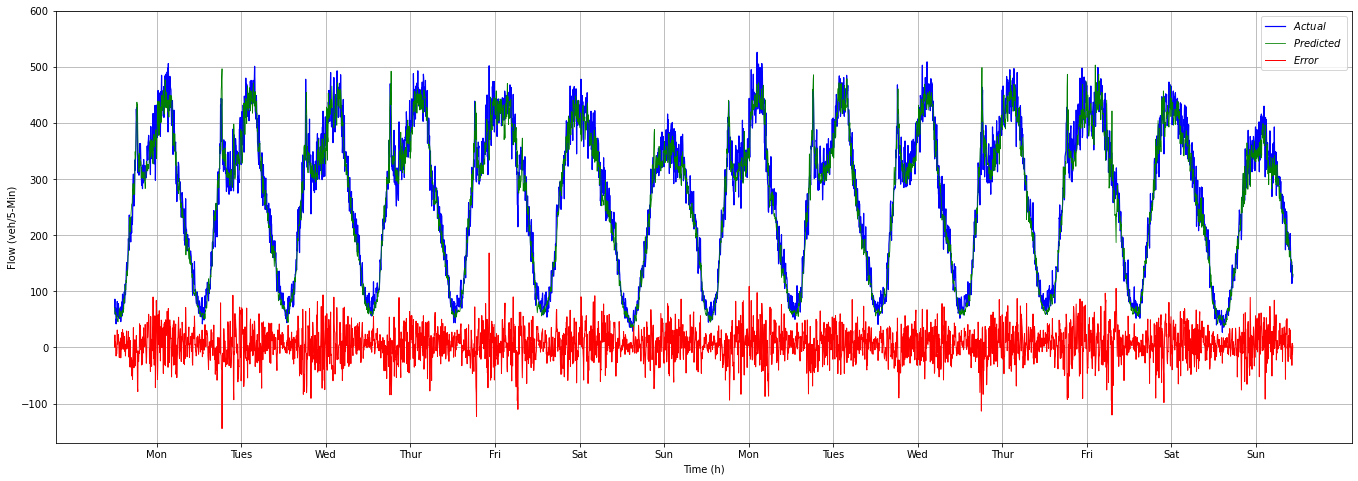

In [54]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv15, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions15, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv15-test_predictions15), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

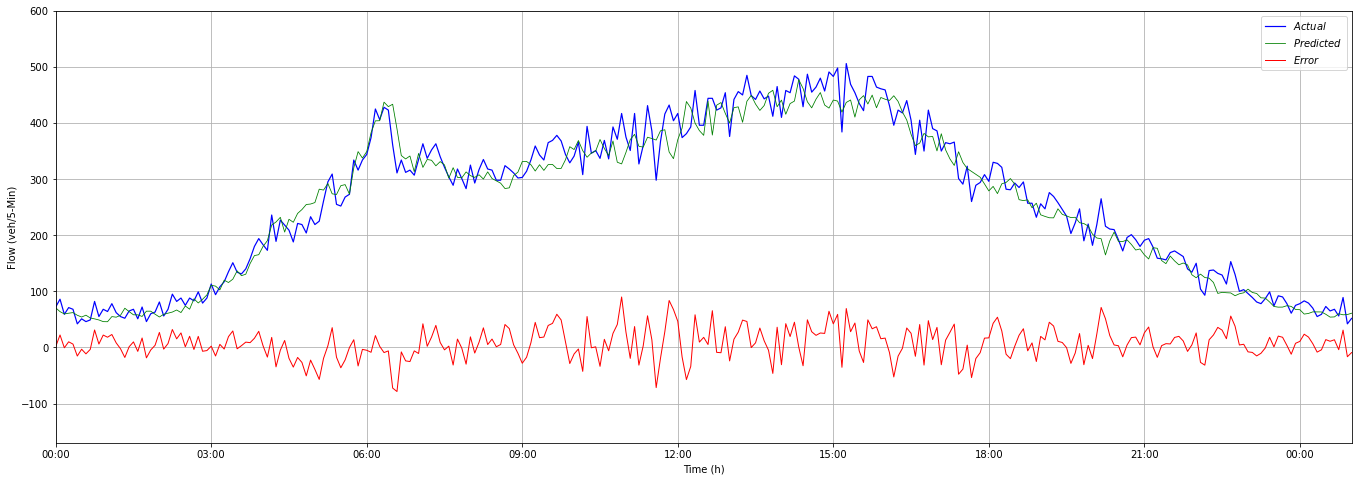

In [55]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv15, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions15, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv15-test_predictions15), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,300)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# 30 mins ahead

In [56]:
def build_model_30(hp):
    # Input
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Deep Model
    # CNN 
    CNN_30 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_30 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_30)
    # LSTM          
    LSTM_30 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_30)
    
    # Output
    output = keras.layers.Dense(1, name= "output")(LSTM_30)
    
    # Model
    model_30 = keras.Model(inputs=[channel_Deep], outputs=[output])

    # Compile
    model_30.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_30

In [57]:
tuner30 = RandomSearch(
    build_model_30,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/Runs'),
    project_name="7b-CNN-LSTM-30",
)

INFO:tensorflow:Reloading Oracle from existing project C:\Runs\7b-CNN-LSTM-30\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Runs\7b-CNN-LSTM-30\tuner0.json


In [58]:
tuner30.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [59]:
tuner30.search((Xt30), yt30, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [60]:
tuner30.results_summary(1)

Results summary
Results in C:\Runs\7b-CNN-LSTM-30
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 160
kernel_size: 2
units_LSTM: 54
learning_rate: 0.001
Score: 0.002542396867647767


### Best model

In [61]:
best_hp30 = tuner30.get_best_hyperparameters()[0]
model30 = tuner30.hypermodel.build(best_hp30)

In [62]:
scaler_filename = "7b-ConvLSTM-30"
joblib.dump(best_hp30, scaler_filename) 

['7b-ConvLSTM-30']

In [63]:
model30.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DeepInput (InputLayer)       [(None, None, 5, 7, 1)]   0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 4, 6, 160)   800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 3840)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 54)                841320    
_________________________________________________________________
output (Dense)               (None, 1)                 55        
Total params: 842,175
Trainable params: 842,175
Non-trainable params: 0
_________________________________________________________________


In [64]:
# model30.fit(Xt30, yt30, 
#             epochs = 100, 
#             verbose = 0)

In [65]:
# metrics30 = pd.DataFrame(model30.history.history)

In [66]:
# metrics30[['loss']].plot()

In [67]:
MSE30  = []
MAE30  = []
RMSE30 = []
MAPE30 = []

for i in range(100):
    print(f"run: {i+1}")
    model30.fit((Xt30), yt30, 
            epochs = 200, validation_split = val_percent,
            callbacks = [stop],
            verbose = 1)
    
    test_predictions30 = model30.predict((Xv30))

    yv30 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv30 = yv30[20:,4]

    df = Test.drop(Test.head(20).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f5'] = pd.Series(test_predictions30.flatten())

    test_predictions30 = scaler.inverse_transform(df)

    test_predictions30 = test_predictions30[:,4]

    MSE30.append(mean_squared_error(yv30,test_predictions30))

    MAE30.append(mean_absolute_error(yv30,test_predictions30))

    RMSE30.append(np.sqrt(mean_squared_error(yv30,test_predictions30)))

    MAPE30.append(mean_absolute_percentage_error(yv30,test_predictions30)*100)

    
    current_mse = mean_squared_error(yv30,test_predictions30)
    if all(i > current_mse for i in MSE30):
        model30.save("my_dir/7b-CNN-LSTM-30")

eval30 = [mean(MSE30), mean(MAE30), mean(RMSE30), mean(MAPE30)]
std30 = [stdev(MSE30), stdev(MAE30), stdev(RMSE30), stdev(MAPE30)]
print(eval30)

run: 1
Epoch 1/200
846/846 [==============================] - 18s 21ms/step - loss: 0.0053 - mean_absolute_error: 0.0527 - root_mean_squared_error: 0.0730 - mean_absolute_percentage_error: 5675.6597 - val_loss: 0.0036 - val_mean_absolute_error: 0.0456 - val_root_mean_squared_error: 0.0602 - val_mean_absolute_percentage_error: 13.3229
Epoch 2/200
846/846 [==============================] - 18s 21ms/step - loss: 0.0037 - mean_absolute_error: 0.0453 - root_mean_squared_error: 0.0609 - mean_absolute_percentage_error: 4032.4663 - val_loss: 0.0039 - val_mean_absolute_error: 0.0499 - val_root_mean_squared_error: 0.0625 - val_mean_absolute_percentage_error: 19.4478an_absolute_e - ETA: 3s - loss: 0.0037 - mean_absolute_error: 0.0454 - root_mean_sq
Epoch 3/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0034 - mean_absolute_error: 0.0433 - root_mean_squared_error: 0.0581 - mean_absolute_percentage_error: 5776.9570 - val_loss: 0.0032 - val_mean_absolute_error: 0.0425 - val_r

846/846 [==============================] - 17s 21ms/step - loss: 0.0022 - mean_absolute_error: 0.0355 - root_mean_squared_error: 0.0474 - mean_absolute_percentage_error: 3443.3662 - val_loss: 0.0027 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0518 - val_mean_absolute_percentage_error: 11.6730
Epoch 7/200
846/846 [==============================] - 17s 21ms/step - loss: 0.0023 - mean_absolute_error: 0.0355 - root_mean_squared_error: 0.0474 - mean_absolute_percentage_error: 3226.1323 - val_loss: 0.0028 - val_mean_absolute_error: 0.0401 - val_root_mean_squared_error: 0.0529 - val_mean_absolute_percentage_error: 12.6241
Epoch 8/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0022 - mean_absolute_error: 0.0355 - root_mean_squared_error: 0.0474 - mean_absolute_percentage_error: 3906.8557 - val_loss: 0.0026 - val_mean_absolute_error: 0.0392 - val_root_mean_squared_error: 0.0514 - val_mean_absolute_percentage_error: 12.2553
Epoch 9/200
846/846 [====

Epoch 6/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0020 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0444 - mean_absolute_percentage_error: 3587.2812 - val_loss: 0.0027 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0520 - val_mean_absolute_percentage_error: 11.8198
Epoch 7/200
846/846 [==============================] - 17s 21ms/step - loss: 0.0020 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0444 - mean_absolute_percentage_error: 3632.7200 - val_loss: 0.0028 - val_mean_absolute_error: 0.0402 - val_root_mean_squared_error: 0.0529 - val_mean_absolute_percentage_error: 12.1326te_error: 0.0333 - root_mean_squared_error: 0.044 - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0444 - mean_absolute_percentage_error: 
Epoch 8/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0020 - mean_absolute_error: 0.0332 - root_mean_squared_error: 0.0442 - mean_absolute_perce

Epoch 4/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0019 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0440 - mean_absolute_percentage_error: 3671.2371 - val_loss: 0.0027 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0519 - val_mean_absolute_percentage_error: 12.1649
Epoch 5/200
846/846 [==============================] - 17s 21ms/step - loss: 0.0019 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0437 - mean_absolute_percentage_error: 3392.0513 - val_loss: 0.0028 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0530 - val_mean_absolute_percentage_error: 12.0874
Epoch 6/200
846/846 [==============================] - 18s 21ms/step - loss: 0.0019 - mean_absolute_error: 0.0327 - root_mean_squared_error: 0.0435 - mean_absolute_percentage_error: 2956.5151 - val_loss: 0.0027 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0522 - val_mean_absolute_percentage_error: 12.0202
Epoch 7/200
8

846/846 [==============================] - 18s 21ms/step - loss: 0.0017 - mean_absolute_error: 0.0307 - root_mean_squared_error: 0.0407 - mean_absolute_percentage_error: 3624.9729 - val_loss: 0.0030 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0545 - val_mean_absolute_percentage_error: 12.2806
Epoch 3/200
846/846 [==============================] - 18s 22ms/step - loss: 0.0017 - mean_absolute_error: 0.0307 - root_mean_squared_error: 0.0407 - mean_absolute_percentage_error: 3660.5127 - val_loss: 0.0029 - val_mean_absolute_error: 0.0407 - val_root_mean_squared_error: 0.0542 - val_mean_absolute_percentage_error: 12.1873
Epoch 4/200
846/846 [==============================] - 18s 22ms/step - loss: 0.0016 - mean_absolute_error: 0.0306 - root_mean_squared_error: 0.0405 - mean_absolute_percentage_error: 3920.9907 - val_loss: 0.0030 - val_mean_absolute_error: 0.0416 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_percentage_error: 12.5890
Epoch 5/200
846/846 [====

846/846 [==============================] - 18s 21ms/step - loss: 0.0015 - mean_absolute_error: 0.0292 - root_mean_squared_error: 0.0385 - mean_absolute_percentage_error: 3692.1348 - val_loss: 0.0032 - val_mean_absolute_error: 0.0426 - val_root_mean_squared_error: 0.0567 - val_mean_absolute_percentage_error: 12.7045
Epoch 2/200
846/846 [==============================] - 18s 22ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0382 - mean_absolute_percentage_error: 3747.4404 - val_loss: 0.0033 - val_mean_absolute_error: 0.0436 - val_root_mean_squared_error: 0.0578 - val_mean_absolute_percentage_error: 13.19480014 - mean_absolute_error: 0.0287 - root_mean_sq
Epoch 3/200
846/846 [==============================] - 18s 22ms/step - loss: 0.0014 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0379 - mean_absolute_percentage_error: 3929.7795 - val_loss: 0.0033 - val_mean_absolute_error: 0.0430 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_pe

846/846 [==============================] - 18s 22ms/step - loss: 0.0012 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0342 - mean_absolute_percentage_error: 3918.4739 - val_loss: 0.0035 - val_mean_absolute_error: 0.0444 - val_root_mean_squared_error: 0.0593 - val_mean_absolute_percentage_error: 12.8445
Epoch 6/200
846/846 [==============================] - 18s 22ms/step - loss: 0.0012 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0342 - mean_absolute_percentage_error: 4304.2192 - val_loss: 0.0035 - val_mean_absolute_error: 0.0444 - val_root_mean_squared_error: 0.0593 - val_mean_absolute_percentage_error: 13.1249
Epoch 7/200
846/846 [==============================] - 17s 20ms/step - loss: 0.0011 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0337 - mean_absolute_percentage_error: 3572.5974 - val_loss: 0.0036 - val_mean_absolute_error: 0.0446 - val_root_mean_squared_error: 0.0597 - val_mean_absolute_percentage_error: 13.1631
Epoch 8/200
846/846 [====

846/846 [==============================] - 18s 21ms/step - loss: 0.0010 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0320 - mean_absolute_percentage_error: 3679.2927 - val_loss: 0.0037 - val_mean_absolute_error: 0.0456 - val_root_mean_squared_error: 0.0608 - val_mean_absolute_percentage_error: 13.0737
Epoch 3/200
846/846 [==============================] - 18s 21ms/step - loss: 0.0010 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0320 - mean_absolute_percentage_error: 3082.9976 - val_loss: 0.0038 - val_mean_absolute_error: 0.0464 - val_root_mean_squared_error: 0.0620 - val_mean_absolute_percentage_error: 13.4379 - mean_absolute_perc - ETA: 2s - loss: 0.0010 - mean_absolute_error: 0.0245 - root_mean_squared_error: 
Epoch 4/200
846/846 [==============================] - 18s 21ms/step - loss: 0.0010 - mean_absolute_error: 0.0244 - root_mean_squared_error: 0.0317 - mean_absolute_percentage_error: 3333.4663 - val_loss: 0.0038 - val_mean_absolute_error: 0.0457 - val

Epoch 5/200
846/846 [==============================] - 18s 21ms/step - loss: 8.6412e-04 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0294 - mean_absolute_percentage_error: 3895.9050 - val_loss: 0.0039 - val_mean_absolute_error: 0.0467 - val_root_mean_squared_error: 0.0624 - val_mean_absolute_percentage_error: 13.6727
Epoch 6/200
846/846 [==============================] - 19s 22ms/step - loss: 8.5931e-04 - mean_absolute_error: 0.0226 - root_mean_squared_error: 0.0293 - mean_absolute_percentage_error: 3154.5537 - val_loss: 0.0040 - val_mean_absolute_error: 0.0469 - val_root_mean_squared_error: 0.0630 - val_mean_absolute_percentage_error: 13.6915
Epoch 7/200
846/846 [==============================] - 19s 22ms/step - loss: 8.3150e-04 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0288 - mean_absolute_percentage_error: 3439.9856 - val_loss: 0.0039 - val_mean_absolute_error: 0.0471 - val_root_mean_squared_error: 0.0628 - val_mean_absolute_percentage_error: 13.6311
E

846/846 [==============================] - 18s 21ms/step - loss: 7.2420e-04 - mean_absolute_error: 0.0208 - root_mean_squared_error: 0.0269 - mean_absolute_percentage_error: 3669.9648 - val_loss: 0.0042 - val_mean_absolute_error: 0.0483 - val_root_mean_squared_error: 0.0647 - val_mean_absolute_percentage_error: 13.9440
Epoch 4/200
846/846 [==============================] - 17s 20ms/step - loss: 7.1625e-04 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0268 - mean_absolute_percentage_error: 3514.0730 - val_loss: 0.0043 - val_mean_absolute_error: 0.0492 - val_root_mean_squared_error: 0.0658 - val_mean_absolute_percentage_error: 14.4278
Epoch 5/200
846/846 [==============================] - 18s 21ms/step - loss: 6.8954e-04 - mean_absolute_error: 0.0203 - root_mean_squared_error: 0.0263 - mean_absolute_percentage_error: 3708.6387 - val_loss: 0.0041 - val_mean_absolute_error: 0.0477 - val_root_mean_squared_error: 0.0637 - val_mean_absolute_percentage_error: 13.7378
Epoch 6/200
8

Epoch 5/200
846/846 [==============================] - 18s 21ms/step - loss: 6.5086e-04 - mean_absolute_error: 0.0198 - root_mean_squared_error: 0.0255 - mean_absolute_percentage_error: 3304.6328 - val_loss: 0.0044 - val_mean_absolute_error: 0.0491 - val_root_mean_squared_error: 0.0660 - val_mean_absolute_percentage_error: 14.2951
Epoch 6/200
846/846 [==============================] - 18s 21ms/step - loss: 6.4231e-04 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0253 - mean_absolute_percentage_error: 3509.2102 - val_loss: 0.0042 - val_mean_absolute_error: 0.0482 - val_root_mean_squared_error: 0.0648 - val_mean_absolute_percentage_error: 14.1910oss: 6.2620e-04 - mean_absolute_er - ETA: 5s - loss: 6.3026e-04 - mean_absol
run: 50
Epoch 1/200
846/846 [==============================] - 18s 22ms/step - loss: 6.8533e-04 - mean_absolute_error: 0.0203 - root_mean_squared_error: 0.0262 - mean_absolute_percentage_error: 3675.1824 - val_loss: 0.0040 - val_mean_absolute_error: 0.0474 -

846/846 [==============================] - 17s 20ms/step - loss: 5.6164e-04 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0237 - mean_absolute_percentage_error: 3439.6428 - val_loss: 0.0043 - val_mean_absolute_error: 0.0487 - val_root_mean_squared_error: 0.0655 - val_mean_absolute_percentage_error: 14.3329
Epoch 5/200
846/846 [==============================] - 18s 21ms/step - loss: 5.6323e-04 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0237 - mean_absolute_percentage_error: 3679.5061 - val_loss: 0.0044 - val_mean_absolute_error: 0.0491 - val_root_mean_squared_error: 0.0661 - val_mean_absolute_percentage_error: 14.3726
Epoch 6/200
846/846 [==============================] - 17s 20ms/step - loss: 5.5076e-04 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0235 - mean_absolute_percentage_error: 3704.2839 - val_loss: 0.0044 - val_mean_absolute_error: 0.0496 - val_root_mean_squared_error: 0.0665 - val_mean_absolute_percentage_error: 14.4826
Epoch 7/200
8

846/846 [==============================] - 17s 20ms/step - loss: 4.7095e-04 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0217 - mean_absolute_percentage_error: 3401.1580 - val_loss: 0.0046 - val_mean_absolute_error: 0.0498 - val_root_mean_squared_error: 0.0676 - val_mean_absolute_percentage_error: 14.4432
Epoch 3/200
846/846 [==============================] - 18s 21ms/step - loss: 4.6592e-04 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0216 - mean_absolute_percentage_error: 3162.0283 - val_loss: 0.0044 - val_mean_absolute_error: 0.0490 - val_root_mean_squared_error: 0.0662 - val_mean_absolute_percentage_error: 14.2803
Epoch 4/200
846/846 [==============================] - 18s 21ms/step - loss: 4.5784e-04 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0214 - mean_absolute_percentage_error: 3233.1160 - val_loss: 0.0047 - val_mean_absolute_error: 0.0511 - val_root_mean_squared_error: 0.0687 - val_mean_absolute_percentage_error: 14.6213
Epoch 5/200
8

846/846 [==============================] - 18s 21ms/step - loss: 4.1925e-04 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0205 - mean_absolute_percentage_error: 3805.8196 - val_loss: 0.0047 - val_mean_absolute_error: 0.0510 - val_root_mean_squared_error: 0.0685 - val_mean_absolute_percentage_error: 14.8517
Epoch 3/200
846/846 [==============================] - 18s 21ms/step - loss: 4.1039e-04 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0203 - mean_absolute_percentage_error: 3129.1899 - val_loss: 0.0047 - val_mean_absolute_error: 0.0508 - val_root_mean_squared_error: 0.0687 - val_mean_absolute_percentage_error: 14.6700
Epoch 4/200
846/846 [==============================] - 18s 22ms/step - loss: 3.9116e-04 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0198 - mean_absolute_percentage_error: 3651.9934 - val_loss: 0.0047 - val_mean_absolute_error: 0.0510 - val_root_mean_squared_error: 0.0689 - val_mean_absolute_percentage_error: 14.6480
Epoch 5/200
8

Epoch 2/200
846/846 [==============================] - 18s 21ms/step - loss: 3.7520e-04 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0194 - mean_absolute_percentage_error: 3407.3430 - val_loss: 0.0046 - val_mean_absolute_error: 0.0500 - val_root_mean_squared_error: 0.0675 - val_mean_absolute_percentage_error: 14.5068
Epoch 3/200
846/846 [==============================] - 18s 21ms/step - loss: 3.7958e-04 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0195 - mean_absolute_percentage_error: 3108.9858 - val_loss: 0.0046 - val_mean_absolute_error: 0.0502 - val_root_mean_squared_error: 0.0682 - val_mean_absolute_percentage_error: 14.4858
Epoch 4/200
846/846 [==============================] - 18s 21ms/step - loss: 3.6846e-04 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0192 - mean_absolute_percentage_error: 4123.5312 - val_loss: 0.0046 - val_mean_absolute_error: 0.0503 - val_root_mean_squared_error: 0.0679 - val_mean_absolute_percentage_error: 14.7583
E

846/846 [==============================] - 19s 22ms/step - loss: 3.1603e-04 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0178 - mean_absolute_percentage_error: 3691.1306 - val_loss: 0.0049 - val_mean_absolute_error: 0.0515 - val_root_mean_squared_error: 0.0697 - val_mean_absolute_percentage_error: 14.8627mean_squared_error: 
Epoch 11/200
846/846 [==============================] - 18s 21ms/step - loss: 3.0966e-04 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0176 - mean_absolute_percentage_error: 3460.2397 - val_loss: 0.0049 - val_mean_absolute_error: 0.0518 - val_root_mean_squared_error: 0.0703 - val_mean_absolute_percentage_error: 14.9365oss: 3.0486e-04 - mean_absolute_error: 0.0136 - root_m - ETA: 4s - loss: 3.0431e-04 - mean_absolute_error: 0.0136 - root_mean_squared_er - ETA: 1s - loss: 3.0913e-04 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0176 - mean_absolute_percent
Epoch 12/200
846/846 [==============================] - 18s 22ms/step - 

846/846 [==============================] - 18s 22ms/step - loss: 2.7119e-04 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0165 - mean_absolute_percentage_error: 2793.2529 - val_loss: 0.0049 - val_mean_absolute_error: 0.0516 - val_root_mean_squared_error: 0.0699 - val_mean_absolute_percentage_error: 14.7633
Epoch 10/200
846/846 [==============================] - 19s 22ms/step - loss: 2.8032e-04 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0167 - mean_absolute_percentage_error: 3615.1162 - val_loss: 0.0048 - val_mean_absolute_error: 0.0511 - val_root_mean_squared_error: 0.0693 - val_mean_absolute_percentage_error: 14.6190
Epoch 11/200
846/846 [==============================] - 18s 21ms/step - loss: 2.7063e-04 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0165 - mean_absolute_percentage_error: 3008.1765 - val_loss: 0.0049 - val_mean_absolute_error: 0.0519 - val_root_mean_squared_error: 0.0699 - val_mean_absolute_percentage_error: 14.9901
Epoch 12/20

846/846 [==============================] - 17s 20ms/step - loss: 2.5736e-04 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0160 - mean_absolute_percentage_error: 3385.7244 - val_loss: 0.0050 - val_mean_absolute_error: 0.0520 - val_root_mean_squared_error: 0.0704 - val_mean_absolute_percentage_error: 15.0840
Epoch 2/200
846/846 [==============================] - 18s 22ms/step - loss: 2.4897e-04 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0158 - mean_absolute_percentage_error: 3008.2605 - val_loss: 0.0048 - val_mean_absolute_error: 0.0513 - val_root_mean_squared_error: 0.0695 - val_mean_absolute_percentage_error: 14.9549
Epoch 3/200
846/846 [==============================] - 19s 22ms/step - loss: 2.4276e-04 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0156 - mean_absolute_percentage_error: 3225.6187 - val_loss: 0.0049 - val_mean_absolute_error: 0.0515 - val_root_mean_squared_error: 0.0696 - val_mean_absolute_percentage_error: 15.1108ercentage_erro

846/846 [==============================] - 18s 22ms/step - loss: 2.2687e-04 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0151 - mean_absolute_percentage_error: 2855.5945 - val_loss: 0.0049 - val_mean_absolute_error: 0.0520 - val_root_mean_squared_error: 0.0701 - val_mean_absolute_percentage_error: 14.95452e-04 - mean_absolu - ETA: 1s - loss: 2.2534e-04 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0150 - mean_abso
Epoch 3/200
846/846 [==============================] - 18s 22ms/step - loss: 2.2602e-04 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0150 - mean_absolute_percentage_error: 3202.1584 - val_loss: 0.0049 - val_mean_absolute_error: 0.0522 - val_root_mean_squared_error: 0.0702 - val_mean_absolute_percentage_error: 15.2765
Epoch 4/200
846/846 [==============================] - 18s 21ms/step - loss: 2.2155e-04 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0149 - mean_absolute_percentage_error: 3222.4163 - val_loss: 0.0049 - val_m

Epoch 5/200
846/846 [==============================] - 19s 22ms/step - loss: 2.1287e-04 - mean_absolute_error: 0.0112 - root_mean_squared_error: 0.0146 - mean_absolute_percentage_error: 3610.2505 - val_loss: 0.0050 - val_mean_absolute_error: 0.0525 - val_root_mean_squared_error: 0.0710 - val_mean_absolute_percentage_error: 15.0998
Epoch 6/200
846/846 [==============================] - 19s 22ms/step - loss: 2.2377e-04 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0150 - mean_absolute_percentage_error: 3099.2756 - val_loss: 0.0050 - val_mean_absolute_error: 0.0522 - val_root_mean_squared_error: 0.0708 - val_mean_absolute_percentage_error: 15.2513
Epoch 7/200
846/846 [==============================] - 18s 21ms/step - loss: 2.1037e-04 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0145 - mean_absolute_percentage_error: 2881.7209 - val_loss: 0.0050 - val_mean_absolute_error: 0.0519 - val_root_mean_squared_error: 0.0704 - val_mean_absolute_percentage_error: 14.9684
r

846/846 [==============================] - 18s 21ms/step - loss: 1.9839e-04 - mean_absolute_error: 0.0108 - root_mean_squared_error: 0.0141 - mean_absolute_percentage_error: 2920.2686 - val_loss: 0.0050 - val_mean_absolute_error: 0.0524 - val_root_mean_squared_error: 0.0707 - val_mean_absolute_percentage_error: 15.1918
run: 100
Epoch 1/200
846/846 [==============================] - 19s 22ms/step - loss: 2.0574e-04 - mean_absolute_error: 0.0110 - root_mean_squared_error: 0.0143 - mean_absolute_percentage_error: 2833.6824 - val_loss: 0.0050 - val_mean_absolute_error: 0.0525 - val_root_mean_squared_error: 0.0709 - val_mean_absolute_percentage_error: 15.2213_absolute_error: 0.0108 -  - ETA: 5s - loss: 2.0452e-04 - mean_absolute_error: 0.0109 - root_mean_squared_error: 0.0143 - mean_absolute_percentage_err - ETA: 4s - loss: 2.0480e-04 - mean_absolute_error: 0.0110 - root_mean_squared_error: 0.0143 - - ETA: 1s - loss: 2.0812e-04 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0144

In [68]:
model30 = keras.models.load_model("my_dir/7b-CNN-LSTM-30")

In [106]:
runs = {'MSE': MSE30, 'MAE': MAE30, 'RMSE': RMSE30, 'MAPE': MAPE30}
table30 = pd.DataFrame(data=runs)
table30.to_csv("Results/Runs/7b-CNN-LSTM-30")

In [107]:
pd.read_csv("Results/Runs/7b-CNN-LSTM-30", index_col=0)

,MSE,MAE,RMSE,MAPE
0,807.480861,21.787104,28.416208,9.679662
1,830.626774,22.159174,28.820596,9.675498
2,805.839463,21.723885,28.387312,9.751617
3,801.215432,21.615305,28.305749,9.623610
4,796.577093,21.676583,28.223697,9.752864
...,...,...,...,...
95,1569.322183,29.942130,39.614671,12.625545
96,1555.575274,29.762954,39.440782,12.561318
97,1573.161551,30.072526,39.663101,12.698736
98,1549.738548,29.753502,39.366719,12.569850


### Evaluation on inverse_transform

In [69]:
test_predictions30 = model30.predict(Xv30)

yv30 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv30 = yv30[20:,4]

df = Test.drop(Test.head(20).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f5'] = pd.Series(test_predictions30.flatten())

test_predictions30 = scaler.inverse_transform(df)

test_predictions30 = test_predictions30[:,4]

# MSE30 = mean_squared_error(yv30,test_predictions30)

# MAE30 = mean_absolute_error(yv30,test_predictions30)

# RMSE30 = np.sqrt(MSE30)

# MAPE30 = mean_absolute_percentage_error(yv30,test_predictions30)*100

# eval30 = [MSE30, MAE30, RMSE30, MAPE30]
# print(eval30)

In [70]:
RA10 = ra.RA_10(np.asarray(yv30), np.asarray(test_predictions30))
RA15 = ra.RA_15(np.asarray(yv30), np.asarray(test_predictions30))
RA20 = ra.RA_20(np.asarray(yv30), np.asarray(test_predictions30))

res30 = [RA10, RA15, RA20]
print(res30)

[59.97008973080757, 76.09670987038884, 85.89232303090728]


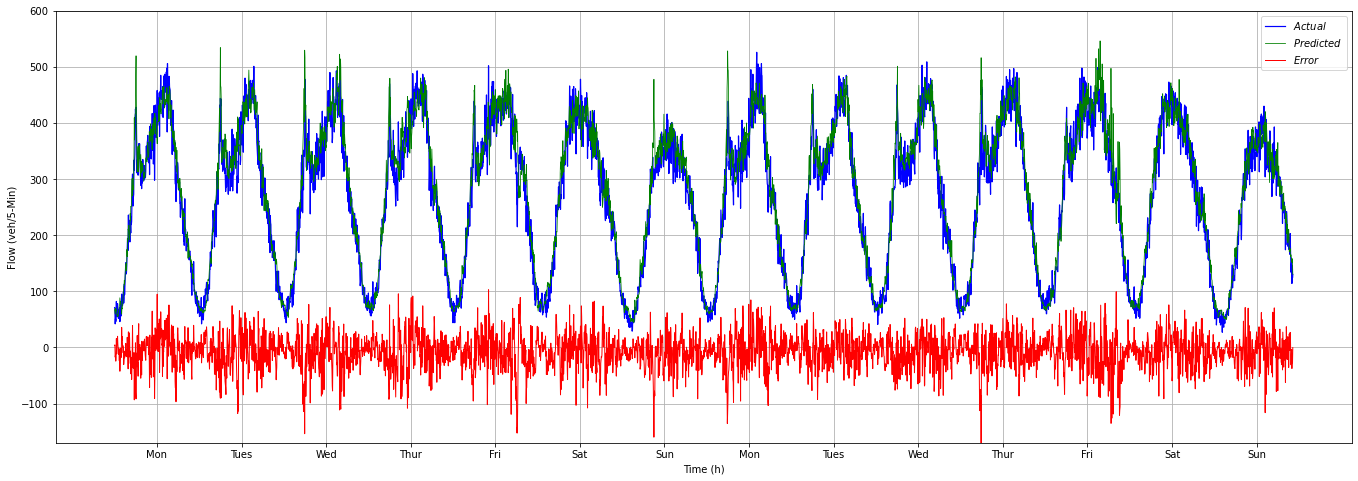

In [71]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv30, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions30, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv30-test_predictions30), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

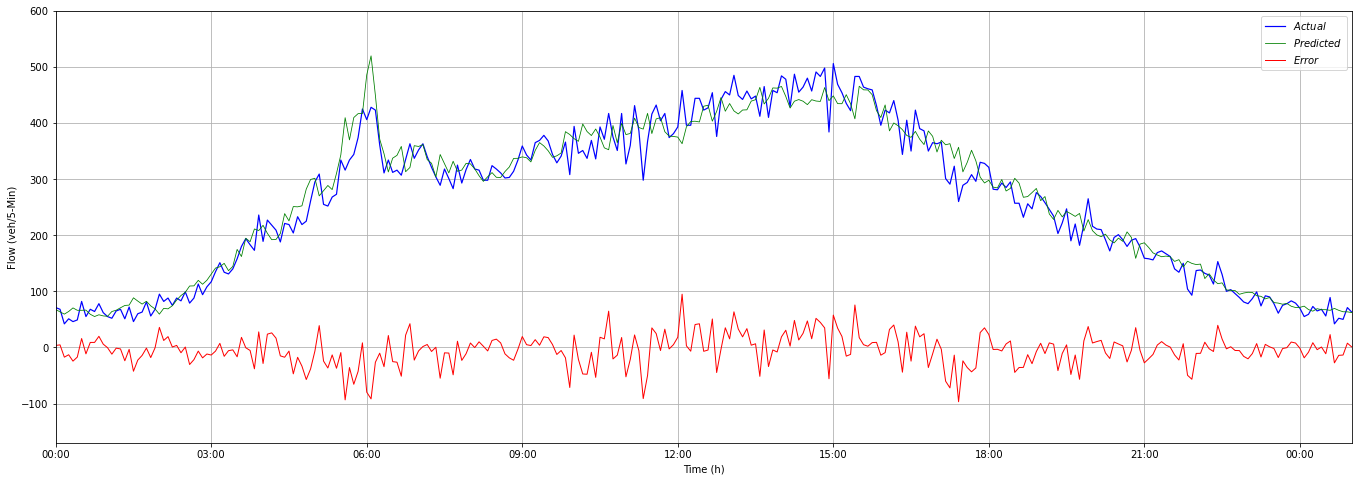

In [72]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv30, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions30, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv30-test_predictions30), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,300)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# 60 mins ahead

In [73]:
def build_model_60(hp):
    # Inputs
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Deep Model
    # CNN 
    CNN_60 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_60 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_60)
    # LSTM          
    LSTM_60 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_60)
    
    # Output
    output = keras.layers.Dense(1, name= "output")(LSTM_60)
    
    # Model
    model_60 = keras.Model(inputs=[channel_Deep], outputs=[output])

    # Compile
    model_60.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_60

In [74]:
tuner60 = RandomSearch(
    build_model_60,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/Runs'),
    project_name="7b-CNN-LSTM-60",
)

INFO:tensorflow:Reloading Oracle from existing project C:\Runs\7b-CNN-LSTM-60\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Runs\7b-CNN-LSTM-60\tuner0.json


In [75]:
tuner60.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [76]:
tuner60.search((Xt60), yt60, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [77]:
tuner60.results_summary(1)

Results summary
Results in C:\Runs\7b-CNN-LSTM-60
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 160
kernel_size: 2
units_LSTM: 76
learning_rate: 0.001
Score: 0.003191985562443733


### Best model

In [78]:
best_hp60 = tuner60.get_best_hyperparameters()[0]
model60 = tuner60.hypermodel.build(best_hp60)

In [79]:
scaler_filename = "Best_HP/7b-ConvLSTM-60"
joblib.dump(best_hp60, scaler_filename) 

['Best_HP/7b-ConvLSTM-60']

In [80]:
model60.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DeepInput (InputLayer)       [(None, None, 5, 7, 1)]   0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 4, 6, 160)   800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 3840)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 76)                1190768   
_________________________________________________________________
output (Dense)               (None, 1)                 77        
Total params: 1,191,645
Trainable params: 1,191,645
Non-trainable params: 0
_________________________________________________________________


In [81]:
# model60.fit(Xt60, yt60, 
#             epochs = 100, 
#             verbose = 0
#             )

In [82]:
# metrics60 = pd.DataFrame(model60.history.history)

In [83]:
# metrics60[['loss']].plot()

In [84]:
MSE60  = []
MAE60  = []
RMSE60 = []
MAPE60 = []

for i in range(100):
    print(f"run: {i+1}")
    model60.fit((Xt60), yt60, 
            epochs = 200, validation_split = val_percent,
            callbacks = [stop],
            verbose = 1
            )
    
    test_predictions60 = model60.predict((Xv60))
    
    yv60 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv60 = yv60[26:,4]

    df = Test.drop(Test.head(26).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f5'] = pd.Series(test_predictions60.flatten())

    test_predictions60 = scaler.inverse_transform(df)

    test_predictions60 = test_predictions60[:,4]
    
    MSE60.append(mean_squared_error(yv60,test_predictions60))

    MAE60.append(mean_absolute_error(yv60,test_predictions60))

    RMSE60.append(np.sqrt(mean_squared_error(yv60,test_predictions60)))

    MAPE60.append(mean_absolute_percentage_error(yv60,test_predictions60)*100)

    
    current_mse = mean_squared_error(yv60,test_predictions60)
    if all(i > current_mse for i in MSE60):
        model60.save("my_dir/7b-CNN-LSTM-60")

eval60 = [mean(MSE60), mean(MAE60), mean(RMSE60), mean(MAPE60)]
std60 = [stdev(MSE60), stdev(MAE60), stdev(RMSE60), stdev(MAPE60)]
print(eval60)

run: 1
Epoch 1/200
846/846 [==============================] - 28s 33ms/step - loss: 0.0073 - mean_absolute_error: 0.0634 - root_mean_squared_error: 0.0856 - mean_absolute_percentage_error: 6417.0166 - val_loss: 0.0066 - val_mean_absolute_error: 0.0641 - val_root_mean_squared_error: 0.0814 - val_mean_absolute_percentage_error: 23.4614
Epoch 2/200
846/846 [==============================] - 26s 31ms/step - loss: 0.0048 - mean_absolute_error: 0.0522 - root_mean_squared_error: 0.0693 - mean_absolute_percentage_error: 5555.1499 - val_loss: 0.0042 - val_mean_absolute_error: 0.0514 - val_root_mean_squared_error: 0.0651 - val_mean_absolute_percentage_error: 19.0754
Epoch 3/200
846/846 [==============================] - 27s 32ms/step - loss: 0.0043 - mean_absolute_error: 0.0496 - root_mean_squared_error: 0.0658 - mean_absolute_percentage_error: 7669.7446 - val_loss: 0.0040 - val_mean_absolute_error: 0.0486 - val_root_mean_squared_error: 0.0632 - val_mean_absolute_percentage_error: 15.8850
Epoch 

846/846 [==============================] - 27s 31ms/step - loss: 0.0027 - mean_absolute_error: 0.0391 - root_mean_squared_error: 0.0516 - mean_absolute_percentage_error: 5610.7969 - val_loss: 0.0038 - val_mean_absolute_error: 0.0463 - val_root_mean_squared_error: 0.0616 - val_mean_absolute_percentage_error: 14.1419
Epoch 2/200
846/846 [==============================] - 27s 32ms/step - loss: 0.0027 - mean_absolute_error: 0.0389 - root_mean_squared_error: 0.0515 - mean_absolute_percentage_error: 4734.7124 - val_loss: 0.0034 - val_mean_absolute_error: 0.0444 - val_root_mean_squared_error: 0.0583 - val_mean_absolute_percentage_error: 13.5397
Epoch 3/200
846/846 [==============================] - 27s 32ms/step - loss: 0.0026 - mean_absolute_error: 0.0388 - root_mean_squared_error: 0.0511 - mean_absolute_percentage_error: 5463.5933 - val_loss: 0.0033 - val_mean_absolute_error: 0.0436 - val_root_mean_squared_error: 0.0577 - val_mean_absolute_percentage_error: 13.2547 - ETA: 7s - loss: 0.0026 

846/846 [==============================] - 28s 33ms/step - loss: 0.0022 - mean_absolute_error: 0.0358 - root_mean_squared_error: 0.0471 - mean_absolute_percentage_error: 4978.0220 - val_loss: 0.0037 - val_mean_absolute_error: 0.0462 - val_root_mean_squared_error: 0.0609 - val_mean_absolute_percentage_error: 14.4815 0.04
Epoch 5/200
846/846 [==============================] - 28s 33ms/step - loss: 0.0022 - mean_absolute_error: 0.0356 - root_mean_squared_error: 0.0469 - mean_absolute_percentage_error: 4773.0503 - val_loss: 0.0038 - val_mean_absolute_error: 0.0463 - val_root_mean_squared_error: 0.0619 - val_mean_absolute_percentage_error: 14.2367
Epoch 6/200
846/846 [==============================] - 28s 33ms/step - loss: 0.0022 - mean_absolute_error: 0.0352 - root_mean_squared_error: 0.0465 - mean_absolute_percentage_error: 4773.7417 - val_loss: 0.0035 - val_mean_absolute_error: 0.0444 - val_root_mean_squared_error: 0.0588 - val_mean_absolute_percentage_error: 13.4814
Epoch 7/200
846/846 

846/846 [==============================] - 27s 32ms/step - loss: 0.0017 - mean_absolute_error: 0.0311 - root_mean_squared_error: 0.0408 - mean_absolute_percentage_error: 4356.9536 - val_loss: 0.0042 - val_mean_absolute_error: 0.0485 - val_root_mean_squared_error: 0.0647 - val_mean_absolute_percentage_error: 14.9759
Epoch 7/200
846/846 [==============================] - 27s 32ms/step - loss: 0.0017 - mean_absolute_error: 0.0310 - root_mean_squared_error: 0.0406 - mean_absolute_percentage_error: 4607.3486 - val_loss: 0.0042 - val_mean_absolute_error: 0.0487 - val_root_mean_squared_error: 0.0651 - val_mean_absolute_percentage_error: 14.4489
run: 15
Epoch 1/200
846/846 [==============================] - 28s 33ms/step - loss: 0.0017 - mean_absolute_error: 0.0315 - root_mean_squared_error: 0.0414 - mean_absolute_percentage_error: 4215.6680 - val_loss: 0.0039 - val_mean_absolute_error: 0.0471 - val_root_mean_squared_error: 0.0623 - val_mean_absolute_percentage_error: 14.3021.0415 - mean_absol

Epoch 4/200
846/846 [==============================] - 27s 32ms/step - loss: 0.0015 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0387 - mean_absolute_percentage_error: 3897.9705 - val_loss: 0.0044 - val_mean_absolute_error: 0.0499 - val_root_mean_squared_error: 0.0661 - val_mean_absolute_percentage_error: 14.6514
Epoch 5/200
846/846 [==============================] - 28s 33ms/step - loss: 0.0015 - mean_absolute_error: 0.0295 - root_mean_squared_error: 0.0386 - mean_absolute_percentage_error: 4407.9307 - val_loss: 0.0042 - val_mean_absolute_error: 0.0487 - val_root_mean_squared_error: 0.0647 - val_mean_absolute_percentage_error: 14.3141e_error: 0.0295 - root_mean_squared_error: 0.0385 - mean_absolute_percentage_error: 4456. - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0295 - root_mean_squared_error: 0.0386 - mean_absolute_percentage_error: 4414.60
Epoch 6/200
846/846 [==============================] - 27s 32ms/step - loss: 0.0015 - mean_absolute_error: 0.0291 - root_m

846/846 [==============================] - 27s 32ms/step - loss: 0.0012 - mean_absolute_error: 0.0264 - root_mean_squared_error: 0.0342 - mean_absolute_percentage_error: 4387.5303 - val_loss: 0.0047 - val_mean_absolute_error: 0.0509 - val_root_mean_squared_error: 0.0685 - val_mean_absolute_percentage_error: 15.0146
Epoch 9/200
846/846 [==============================] - 28s 33ms/step - loss: 0.0011 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0338 - mean_absolute_percentage_error: 4043.8291 - val_loss: 0.0044 - val_mean_absolute_error: 0.0499 - val_root_mean_squared_error: 0.0666 - val_mean_absolute_percentage_error: 14.6013
Epoch 10/200
846/846 [==============================] - 28s 33ms/step - loss: 0.0011 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0336 - mean_absolute_percentage_error: 3636.7324 - val_loss: 0.0048 - val_mean_absolute_error: 0.0518 - val_root_mean_squared_error: 0.0695 - val_mean_absolute_percentage_error: 15.7047
Epoch 11/200
846/846 [==

846/846 [==============================] - 27s 32ms/step - loss: 9.4065e-04 - mean_absolute_error: 0.0237 - root_mean_squared_error: 0.0307 - mean_absolute_percentage_error: 4539.3984 - val_loss: 0.0051 - val_mean_absolute_error: 0.0528 - val_root_mean_squared_error: 0.0715 - val_mean_absolute_percentage_error: 15.5348
Epoch 7/200
846/846 [==============================] - 27s 32ms/step - loss: 9.3147e-04 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0305 - mean_absolute_percentage_error: 3914.6765 - val_loss: 0.0051 - val_mean_absolute_error: 0.0529 - val_root_mean_squared_error: 0.0713 - val_mean_absolute_percentage_error: 15.6919
Epoch 8/200
846/846 [==============================] - 28s 33ms/step - loss: 8.9953e-04 - mean_absolute_error: 0.0232 - root_mean_squared_error: 0.0300 - mean_absolute_percentage_error: 3793.3364 - val_loss: 0.0051 - val_mean_absolute_error: 0.0524 - val_root_mean_squared_error: 0.0712 - val_mean_absolute_percentage_error: 15.3008
Epoch 9/200
8

846/846 [==============================] - 27s 32ms/step - loss: 7.2344e-04 - mean_absolute_error: 0.0209 - root_mean_squared_error: 0.0269 - mean_absolute_percentage_error: 3540.7073 - val_loss: 0.0056 - val_mean_absolute_error: 0.0552 - val_root_mean_squared_error: 0.0746 - val_mean_absolute_percentage_error: 16.2771 loss: 7.1098e-04 - mean_absolute_error: 0.0208 - root_mean_squared_error: 0.02 - ETA: 1s - loss: 7.1752e-04 - mean_absolute_error: 0.0208 - root_mean_squared_error: 0.0268 - mean_absolute_perce
Epoch 8/200
846/846 [==============================] - 27s 32ms/step - loss: 7.0506e-04 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0266 - mean_absolute_percentage_error: 3791.7095 - val_loss: 0.0054 - val_mean_absolute_error: 0.0543 - val_root_mean_squared_error: 0.0732 - val_mean_absolute_percentage_error: 15.9163
Epoch 9/200
846/846 [==============================] - 27s 32ms/step - loss: 7.0335e-04 - mean_absolute_error: 0.0206 - root_mean_squared_error: 0.0265 

846/846 [==============================] - 27s 32ms/step - loss: 6.1045e-04 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0247 - mean_absolute_percentage_error: 3723.7739 - val_loss: 0.0056 - val_mean_absolute_error: 0.0554 - val_root_mean_squared_error: 0.0748 - val_mean_absolute_percentage_error: 15.9365
Epoch 9/200
846/846 [==============================] - 27s 32ms/step - loss: 5.9367e-04 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0244 - mean_absolute_percentage_error: 3716.6677 - val_loss: 0.0055 - val_mean_absolute_error: 0.0545 - val_root_mean_squared_error: 0.0741 - val_mean_absolute_percentage_error: 15.8493
Epoch 10/200
846/846 [==============================] - 28s 33ms/step - loss: 5.8591e-04 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0242 - mean_absolute_percentage_error: 3067.1665 - val_loss: 0.0057 - val_mean_absolute_error: 0.0557 - val_root_mean_squared_error: 0.0758 - val_mean_absolute_percentage_error: 16.3717
Epoch 11/200

run: 43
Epoch 1/200
846/846 [==============================] - 28s 33ms/step - loss: 5.9245e-04 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0243 - mean_absolute_percentage_error: 3824.6619 - val_loss: 0.0056 - val_mean_absolute_error: 0.0553 - val_root_mean_squared_error: 0.0746 - val_mean_absolute_percentage_error: 16.1023
Epoch 2/200
846/846 [==============================] - 27s 32ms/step - loss: 5.6457e-04 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0238 - mean_absolute_percentage_error: 3962.9316 - val_loss: 0.0057 - val_mean_absolute_error: 0.0555 - val_root_mean_squared_error: 0.0754 - val_mean_absolute_percentage_error: 16.1722
Epoch 3/200
846/846 [==============================] - 27s 32ms/step - loss: 5.7140e-04 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0239 - mean_absolute_percentage_error: 3943.9343 - val_loss: 0.0057 - val_mean_absolute_error: 0.0553 - val_root_mean_squared_error: 0.0754 - val_mean_absolute_percentage_error: 1

846/846 [==============================] - 26s 31ms/step - loss: 4.8261e-04 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0220 - mean_absolute_percentage_error: 3355.2793 - val_loss: 0.0061 - val_mean_absolute_error: 0.0566 - val_root_mean_squared_error: 0.0778 - val_mean_absolute_percentage_error: 16.4689
Epoch 5/200
846/846 [==============================] - 27s 32ms/step - loss: 4.8106e-04 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0219 - mean_absolute_percentage_error: 3648.9587 - val_loss: 0.0058 - val_mean_absolute_error: 0.0563 - val_root_mean_squared_error: 0.0764 - val_mean_absolute_percentage_error: 16.3975e-04 - mean_absolute_error: 0.017
Epoch 6/200
846/846 [==============================] - 26s 31ms/step - loss: 4.7864e-04 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0219 - mean_absolute_percentage_error: 3443.8987 - val_loss: 0.0057 - val_mean_absolute_error: 0.0558 - val_root_mean_squared_error: 0.0758 - val_mean_absolute_percen

846/846 [==============================] - 26s 30ms/step - loss: 4.2228e-04 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0205 - mean_absolute_percentage_error: 3873.9067 - val_loss: 0.0061 - val_mean_absolute_error: 0.0575 - val_root_mean_squared_error: 0.0782 - val_mean_absolute_percentage_error: 16.5633
Epoch 4/200
846/846 [==============================] - 25s 30ms/step - loss: 3.9879e-04 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0200 - mean_absolute_percentage_error: 3711.8621 - val_loss: 0.0063 - val_mean_absolute_error: 0.0585 - val_root_mean_squared_error: 0.0795 - val_mean_absolute_percentage_error: 16.9997
Epoch 5/200
846/846 [==============================] - 26s 31ms/step - loss: 4.0770e-04 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0202 - mean_absolute_percentage_error: 3437.2383 - val_loss: 0.0061 - val_mean_absolute_error: 0.0571 - val_root_mean_squared_error: 0.0779 - val_mean_absolute_percentage_error: 16.4975
Epoch 6/200
8

Epoch 13/200
846/846 [==============================] - 25s 30ms/step - loss: 3.6189e-04 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0190 - mean_absolute_percentage_error: 3314.0898 - val_loss: 0.0060 - val_mean_absolute_error: 0.0571 - val_root_mean_squared_error: 0.0777 - val_mean_absolute_percentage_error: 16.7774
Epoch 14/200
846/846 [==============================] - 25s 30ms/step - loss: 3.6274e-04 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0190 - mean_absolute_percentage_error: 3197.0405 - val_loss: 0.0062 - val_mean_absolute_error: 0.0580 - val_root_mean_squared_error: 0.0784 - val_mean_absolute_percentage_error: 16.7720
Epoch 15/200
846/846 [==============================] - 25s 29ms/step - loss: 3.5783e-04 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0189 - mean_absolute_percentage_error: 3260.6816 - val_loss: 0.0060 - val_mean_absolute_error: 0.0575 - val_root_mean_squared_error: 0.0778 - val_mean_absolute_percentage_error: 16.760

846/846 [==============================] - 26s 31ms/step - loss: 3.2484e-04 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0180 - mean_absolute_percentage_error: 3799.8909 - val_loss: 0.0063 - val_mean_absolute_error: 0.0585 - val_root_mean_squared_error: 0.0791 - val_mean_absolute_percentage_error: 16.8229
Epoch 2/200
846/846 [==============================] - 26s 30ms/step - loss: 3.3097e-04 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0182 - mean_absolute_percentage_error: 3933.6853 - val_loss: 0.0060 - val_mean_absolute_error: 0.0574 - val_root_mean_squared_error: 0.0776 - val_mean_absolute_percentage_error: 16.6034
Epoch 3/200
846/846 [==============================] - 26s 30ms/step - loss: 3.2050e-04 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0179 - mean_absolute_percentage_error: 4446.2788 - val_loss: 0.0062 - val_mean_absolute_error: 0.0580 - val_root_mean_squared_error: 0.0789 - val_mean_absolute_percentage_error: 16.9035
Epoch 4/200
8

Epoch 6/200
846/846 [==============================] - 27s 32ms/step - loss: 2.8442e-04 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0169 - mean_absolute_percentage_error: 3491.5591 - val_loss: 0.0062 - val_mean_absolute_error: 0.0583 - val_root_mean_squared_error: 0.0786 - val_mean_absolute_percentage_error: 17.2237
Epoch 7/200
846/846 [==============================] - 27s 31ms/step - loss: 2.8776e-04 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0170 - mean_absolute_percentage_error: 2859.7004 - val_loss: 0.0063 - val_mean_absolute_error: 0.0585 - val_root_mean_squared_error: 0.0792 - val_mean_absolute_percentage_error: 17.2124
Epoch 8/200
846/846 [==============================] - 27s 32ms/step - loss: 2.7723e-04 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0167 - mean_absolute_percentage_error: 3386.0818 - val_loss: 0.0061 - val_mean_absolute_error: 0.0578 - val_root_mean_squared_error: 0.0780 - val_mean_absolute_percentage_error: 16.8698
E

846/846 [==============================] - 25s 30ms/step - loss: 2.5848e-04 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0161 - mean_absolute_percentage_error: 3413.9062 - val_loss: 0.0060 - val_mean_absolute_error: 0.0575 - val_root_mean_squared_error: 0.0775 - val_mean_absolute_percentage_error: 16.9743
Epoch 9/200
846/846 [==============================] - 26s 30ms/step - loss: 2.4893e-04 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0158 - mean_absolute_percentage_error: 3686.8921 - val_loss: 0.0062 - val_mean_absolute_error: 0.0582 - val_root_mean_squared_error: 0.0787 - val_mean_absolute_percentage_error: 17.1354
Epoch 10/200
846/846 [==============================] - 25s 30ms/step - loss: 2.5228e-04 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0159 - mean_absolute_percentage_error: 3829.4998 - val_loss: 0.0062 - val_mean_absolute_error: 0.0584 - val_root_mean_squared_error: 0.0789 - val_mean_absolute_percentage_error: 17.0943
Epoch 11/200

846/846 [==============================] - 26s 30ms/step - loss: 2.4095e-04 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0155 - mean_absolute_percentage_error: 2541.3977 - val_loss: 0.0062 - val_mean_absolute_error: 0.0583 - val_root_mean_squared_error: 0.0789 - val_mean_absolute_percentage_error: 17.1910
Epoch 4/200
846/846 [==============================] - 25s 30ms/step - loss: 2.4766e-04 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0157 - mean_absolute_percentage_error: 3636.6355 - val_loss: 0.0062 - val_mean_absolute_error: 0.0585 - val_root_mean_squared_error: 0.0790 - val_mean_absolute_percentage_error: 17.2819
Epoch 5/200
846/846 [==============================] - 26s 30ms/step - loss: 2.2750e-04 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0151 - mean_absolute_percentage_error: 2920.8926 - val_loss: 0.0062 - val_mean_absolute_error: 0.0586 - val_root_mean_squared_error: 0.0789 - val_mean_absolute_percentage_error: 17.2046
Epoch 6/200
8

Epoch 9/200
846/846 [==============================] - 25s 29ms/step - loss: 2.1870e-04 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0148 - mean_absolute_percentage_error: 2673.6550 - val_loss: 0.0061 - val_mean_absolute_error: 0.0578 - val_root_mean_squared_error: 0.0779 - val_mean_absolute_percentage_error: 17.0159
Epoch 10/200
846/846 [==============================] - 25s 29ms/step - loss: 2.1035e-04 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0145 - mean_absolute_percentage_error: 2531.4038 - val_loss: 0.0062 - val_mean_absolute_error: 0.0583 - val_root_mean_squared_error: 0.0786 - val_mean_absolute_percentage_error: 17.2454
Epoch 11/200
846/846 [==============================] - 24s 29ms/step - loss: 2.1297e-04 - mean_absolute_error: 0.0112 - root_mean_squared_error: 0.0146 - mean_absolute_percentage_error: 2470.4675 - val_loss: 0.0062 - val_mean_absolute_error: 0.0582 - val_root_mean_squared_error: 0.0786 - val_mean_absolute_percentage_error: 17.0005

846/846 [==============================] - 24s 29ms/step - loss: 2.0712e-04 - mean_absolute_error: 0.0110 - root_mean_squared_error: 0.0144 - mean_absolute_percentage_error: 2442.7561 - val_loss: 0.0062 - val_mean_absolute_error: 0.0581 - val_root_mean_squared_error: 0.0787 - val_mean_absolute_percentage_error: 17.2957_mean_squared_error: 0.0144
Epoch 3/200
846/846 [==============================] - 25s 30ms/step - loss: 2.1265e-04 - mean_absolute_error: 0.0112 - root_mean_squared_error: 0.0146 - mean_absolute_percentage_error: 2811.9419 - val_loss: 0.0062 - val_mean_absolute_error: 0.0584 - val_root_mean_squared_error: 0.0786 - val_mean_absolute_percentage_error: 17.2072
Epoch 4/200
846/846 [==============================] - 24s 28ms/step - loss: 2.1252e-04 - mean_absolute_error: 0.0112 - root_mean_squared_error: 0.0146 - mean_absolute_percentage_error: 2823.7339 - val_loss: 0.0064 - val_mean_absolute_error: 0.0593 - val_root_mean_squared_error: 0.0797 - val_mean_absolute_percentage_e

846/846 [==============================] - 25s 29ms/step - loss: 2.0196e-04 - mean_absolute_error: 0.0109 - root_mean_squared_error: 0.0142 - mean_absolute_percentage_error: 2644.5471 - val_loss: 0.0063 - val_mean_absolute_error: 0.0590 - val_root_mean_squared_error: 0.0793 - val_mean_absolute_percentage_error: 17.2089
run: 92
Epoch 1/200
846/846 [==============================] - 25s 30ms/step - loss: 2.0101e-04 - mean_absolute_error: 0.0109 - root_mean_squared_error: 0.0142 - mean_absolute_percentage_error: 2965.5115 - val_loss: 0.0061 - val_mean_absolute_error: 0.0577 - val_root_mean_squared_error: 0.0778 - val_mean_absolute_percentage_error: 17.2135
Epoch 2/200
846/846 [==============================] - 25s 29ms/step - loss: 2.0271e-04 - mean_absolute_error: 0.0109 - root_mean_squared_error: 0.0142 - mean_absolute_percentage_error: 1967.1416 - val_loss: 0.0065 - val_mean_absolute_error: 0.0597 - val_root_mean_squared_error: 0.0806 - val_mean_absolute_percentage_error: 17.6604
Epoch

846/846 [==============================] - 25s 30ms/step - loss: 1.9253e-04 - mean_absolute_error: 0.0106 - root_mean_squared_error: 0.0139 - mean_absolute_percentage_error: 2360.2654 - val_loss: 0.0062 - val_mean_absolute_error: 0.0586 - val_root_mean_squared_error: 0.0790 - val_mean_absolute_percentage_error: 17.3615
Epoch 7/200
846/846 [==============================] - 25s 29ms/step - loss: 1.7914e-04 - mean_absolute_error: 0.0103 - root_mean_squared_error: 0.0134 - mean_absolute_percentage_error: 2272.0315 - val_loss: 0.0062 - val_mean_absolute_error: 0.0590 - val_root_mean_squared_error: 0.0789 - val_mean_absolute_percentage_error: 17.7425
Epoch 8/200
846/846 [==============================] - 25s 29ms/step - loss: 1.7474e-04 - mean_absolute_error: 0.0101 - root_mean_squared_error: 0.0132 - mean_absolute_percentage_error: 2318.9673 - val_loss: 0.0062 - val_mean_absolute_error: 0.0586 - val_root_mean_squared_error: 0.0788 - val_mean_absolute_percentage_error: 17.3694
Epoch 9/200
8

In [85]:
model60 = keras.models.load_model("my_dir/7b-CNN-LSTM-60")

In [108]:
runs = {'MSE': MSE60, 'MAE': MAE60, 'RMSE': RMSE60, 'MAPE': MAPE60}
table60 = pd.DataFrame(data=runs)
table60.to_csv("Results/Runs/7b-CNN-LSTM-60")

In [109]:
pd.read_csv("Results/Runs/7b-CNN-LSTM-60", index_col=0)

,MSE,MAE,RMSE,MAPE
0,1086.772578,25.275629,32.966234,11.099232
1,985.362055,24.063971,31.390477,10.667509
2,964.458077,23.626002,31.055725,10.477210
3,1025.569466,24.163384,32.024514,10.510085
4,956.232528,23.661561,30.923010,10.363676
...,...,...,...,...
95,1715.077770,31.231589,41.413497,13.267236
96,1755.768980,31.555285,41.901897,13.369616
97,1733.316452,31.355689,41.633117,13.462259
98,1727.649250,31.428460,41.565000,13.371777


### Evaluation on inverse_transform

In [86]:
test_predictions60 = model60.predict((Xv60))

yv60 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv60 = yv60[26:,4]

df = Test.drop(Test.head(26).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f5'] = pd.Series(test_predictions60.flatten())

test_predictions60 = scaler.inverse_transform(df)

test_predictions60 = test_predictions60[:,4]

# MSE60 = mean_squared_error(yv60,test_predictions60)

# MAE60 = mean_absolute_error(yv60,test_predictions60)

# RMSE60 = np.sqrt(MSE60)

# MAPE60 = mean_absolute_percentage_error(yv60,test_predictions60)*100

# eval60 = [MSE60, MAE60, RMSE60, MAPE60]
# print(eval60)

In [87]:
RA10 = ra.RA_10(np.asarray(yv60), np.asarray(test_predictions60))
RA15 = ra.RA_15(np.asarray(yv60), np.asarray(test_predictions60))
RA20 = ra.RA_20(np.asarray(yv60), np.asarray(test_predictions60))

res60 = [RA10, RA15, RA20]
print(res60)

[56.44033949076386, 73.5646530204693, 84.12381427858213]


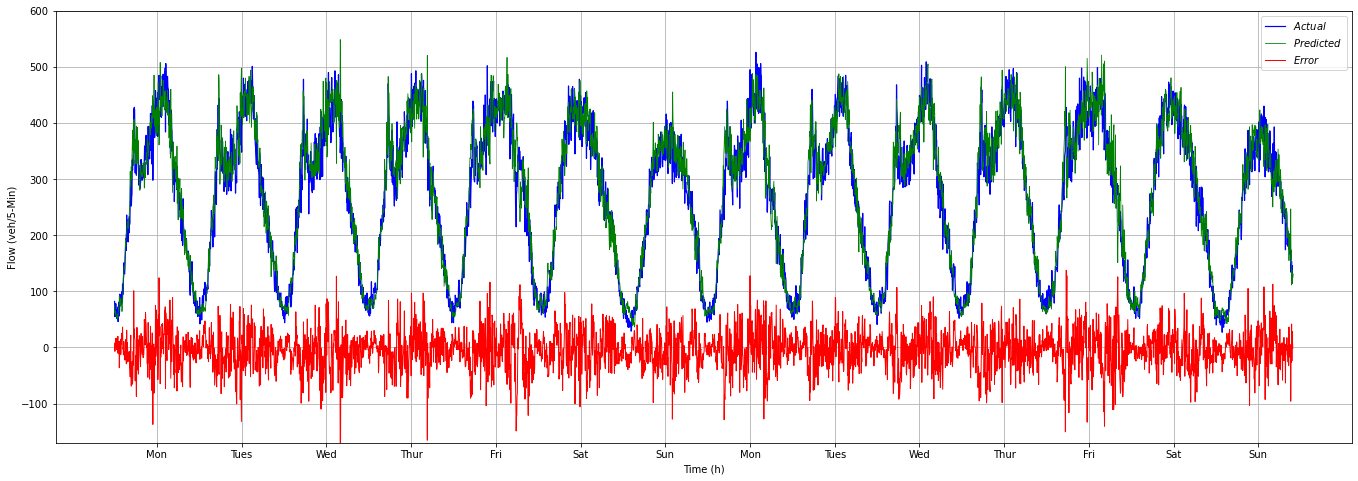

In [88]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv60, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions60, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv60-test_predictions60), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

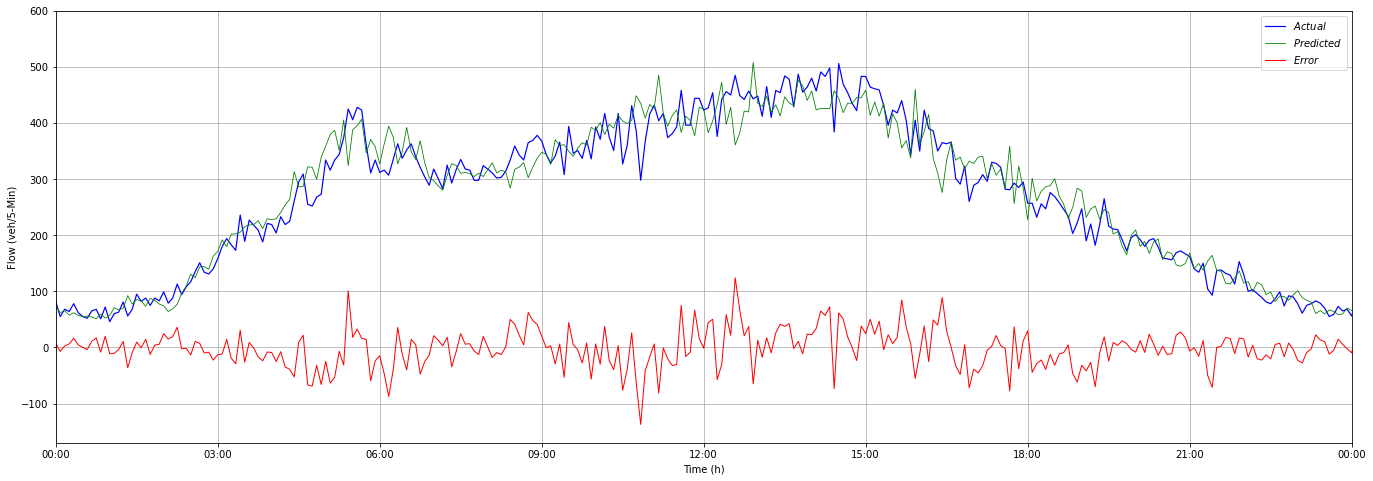

In [89]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv60, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions60, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv60-test_predictions60), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,24)
axes.set_ylim(-170,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# RESULTS

## General results

In [90]:
l = ['MSE','MAE','RMSE','MAPE','Horizon']

In [91]:
eval5.append(5)
eval15.append(15)
eval30.append(30)
eval60.append(60)

In [92]:
df = pd.DataFrame(np.array([eval5,eval15,eval30,eval60]),columns=l)
df.set_index('Horizon')

,MSE,MAE,RMSE,MAPE
Horizon,,,,
5.0,785.574123,20.874425,27.801915,8.880299
15.0,1068.289142,24.490341,32.471101,10.508103
30.0,1251.203898,26.592676,35.159051,11.354235
60.0,1545.530962,29.512832,39.159037,12.545505


## Relative accuracy

In [93]:
m = ['10%','15%','20%','Horizon']

In [94]:
res5.append(5)
res15.append(15)
res30.append(30)
res60.append(60)

In [95]:
df1 = pd.DataFrame(np.array([res5,res15,res30,res60]),columns=m)
df1.set_index('Horizon')

,10%,15%,20%
Horizon,,,
5.0,70.126960,85.212845,93.104307
15.0,61.967621,79.377335,89.041096
30.0,59.970090,76.096710,85.892323
60.0,56.440339,73.564653,84.123814


## Save

In [96]:
x = np.array([eval5, eval15, eval30, eval60])
y = np.array([std5, std15, std30, std60])

In [97]:
np.savez("Results/7a", x=x , y=y)